# eWRC Scraper

`ewrc-results.com` is a comprehensive rally results service.

Let's see if we can build a data downloader and generate some reports from their data...

Simple js API that filters on WRC...: https://github.com/nathanjliu/WRC-API

(For Tendring, there were also results at https://www.rallies.info/res.php?e=296 .)

In [1]:
import pandas as pd
import re
from dakar_utils import getTime

In [2]:
url= 'https://www.ewrc-results.com/final/54762-corbeau-seats-rally-tendring-clacton-2019/'

![](images/eWRC-final_results.png)

In [3]:
pd.read_html(url)[0].head()
# The final results page may also contain a list of retirements

,0,1,2,3,4,5,6,7,8,9,10,11
0,1.,#1,NaN,Preston Thomas - Williamson Carl,NaN,Škoda Fabia R5,SP ***,E,NaN,50:50.2,NaN,101.8
1,2.,#4,NaN,O'Brien Michael - Glennerster Mark,NaN,Ford Focus RS WRC '08,EA0***,E,NaN,50:55.8,+5.6 +5.6,101.6 0.06
2,3.,#26,NaN,Jones Craig - Taylor Ian,NaN,Mitsubishi Lancer Evo IX,PNZ***,E,NaN,52:27.2,+1:37.0 +1:31.4,98.7 1.12
3,4.,#44,NaN,Anderson Guy - Link Stephen,NaN,Mitsubishi Galant VR-4,J14***,H4b,NaN,53:27.7,+2:37.5 +1:00.5,96.8 1.83
4,5.,#8,NaN,Self James - Davis Ian,NaN,Ford Fiesta R5,PX1***,E,NaN,53:29.1,+2:38.9 +1.4,96.8 1.84


How do we get the nested HTML out?

*It would be nice if this issue around converters was addressed? https://github.com/pandas-dev/pandas/issues/14608 *



In [4]:
import requests

html = requests.get(url).text

In [26]:
#https://stackoverflow.com/a/31772009/454773
import lxml.html as LH
from bs4 import BeautifulSoup
from io import StringIO

soup = BeautifulSoup(html, 'lxml') # Parse the HTML as a string
    
tables = soup.find_all('table')
rows = tables[0].find_all('tr')
#tables = LH.fromstring(html).xpath('//table')
_tables = []
current_table = []
for row in rows:
    separator = row.find('td', colspan="12")  # Check for specific colspan="12"
    if separator:  # If the separator is found
        if current_table:  # Add the current group of rows as a table
            _tables.append(current_table)
            current_table = []
    else:
        current_table.append(row)

if current_table:  # Add the last table if rows are left
    _tables.append(current_table)

df_rally_overall = pd.read_html(StringIO('<html><body><table>{}</table></body></html>'.format(_tables[0])))[0]
#df_rally_overall['badge'] = [img.find('img')['src'] for img in tables[0].findAll("td", {"class": "final-results-icon"}) ]
df_rally_overall.dropna(how='all', axis=1, inplace=True)
df_rally_overall.dropna(how='all', axis=0, inplace=True)
df_rally_overall.head()

,0,1,3,5,6,7,9,10,11
0,1.0,#1,Preston Thomas - Williamson Carl,Škoda Fabia R5,SP ***,E,50:50.2,NaN,101.8
1,2.0,#4,O'Brien Michael - Glennerster Mark,Ford Focus RS WRC '08,EA0***,E,50:55.8,+5.6 +5.6,101.6 0.06
2,3.0,#26,Jones Craig - Taylor Ian,Mitsubishi Lancer Evo IX,PNZ***,E,52:27.2,+1:37.0 +1:31.4,98.7 1.12
3,4.0,#44,Anderson Guy - Link Stephen,Mitsubishi Galant VR-4,J14***,H4b,53:27.7,+2:37.5 +1:00.5,96.8 1.83
4,5.0,#8,Self James - Davis Ian,Ford Fiesta R5,PX1***,E,53:29.1,+2:38.9 +1.4,96.8 1.84


In [27]:
#list(df_rally_overall[2])

In [28]:
#df_rally_overall.columns=['Pos','CarNum','driverNav','ModelReg','Class', 'Time','GapDiff', 'Speedkm', 'badge']
df_rally_overall.columns=['Pos','CarNum','driverNav','Model', 'Plate', 'Class', 'Time','GapDiff', 'Speedkm']

In [29]:
#Get the entry ID - use this as the unique key
#in column 3, <a title='Entry info and stats'>
df_rally_overall['entryId']=[a['href'] for a in tables[0].findAll("a", {"title": "Entry info and stats"}) ]
df_rally_overall.set_index('entryId', inplace=True)
df_rally_overall.head()

,Pos,CarNum,driverNav,Model,Registration,Class,Time,GapDiff,Speedkm
entryId,,,,,,,,,
/entryinfo/54762-corbeau-seats-rally-tendring-clacton-2019/2189561/,1.0,#1,Preston Thomas - Williamson Carl,Škoda Fabia R5,SP ***,E,50:50.2,NaN,101.8
/entryinfo/54762-corbeau-seats-rally-tendring-clacton-2019/2162347/,2.0,#4,O'Brien Michael - Glennerster Mark,Ford Focus RS WRC '08,EA0***,E,50:55.8,+5.6 +5.6,101.6 0.06
/entryinfo/54762-corbeau-seats-rally-tendring-clacton-2019/2226943/,3.0,#26,Jones Craig - Taylor Ian,Mitsubishi Lancer Evo IX,PNZ***,E,52:27.2,+1:37.0 +1:31.4,98.7 1.12
/entryinfo/54762-corbeau-seats-rally-tendring-clacton-2019/2162362/,4.0,#44,Anderson Guy - Link Stephen,Mitsubishi Galant VR-4,J14***,H4b,53:27.7,+2:37.5 +1:00.5,96.8 1.83
/entryinfo/54762-corbeau-seats-rally-tendring-clacton-2019/2162350/,5.0,#8,Self James - Davis Ian,Ford Fiesta R5,PX1***,E,53:29.1,+2:38.9 +1.4,96.8 1.84


In [30]:
df_rally_overall[['Driver','CoDriver']] = df_rally_overall['driverNav'].str.extract(r'(?P<Driver>.*)\s+-\s+(?P<CoDriver>.*)')
df_rally_overall.head()

,Pos,CarNum,driverNav,Model,Registration,Class,Time,GapDiff,Speedkm,Driver,CoDriver
entryId,,,,,,,,,,,
/entryinfo/54762-corbeau-seats-rally-tendring-clacton-2019/2189561/,1.0,#1,Preston Thomas - Williamson Carl,Škoda Fabia R5,SP ***,E,50:50.2,NaN,101.8,Preston Thomas,Williamson Carl
/entryinfo/54762-corbeau-seats-rally-tendring-clacton-2019/2162347/,2.0,#4,O'Brien Michael - Glennerster Mark,Ford Focus RS WRC '08,EA0***,E,50:55.8,+5.6 +5.6,101.6 0.06,O'Brien Michael,Glennerster Mark
/entryinfo/54762-corbeau-seats-rally-tendring-clacton-2019/2226943/,3.0,#26,Jones Craig - Taylor Ian,Mitsubishi Lancer Evo IX,PNZ***,E,52:27.2,+1:37.0 +1:31.4,98.7 1.12,Jones Craig,Taylor Ian
/entryinfo/54762-corbeau-seats-rally-tendring-clacton-2019/2162362/,4.0,#44,Anderson Guy - Link Stephen,Mitsubishi Galant VR-4,J14***,H4b,53:27.7,+2:37.5 +1:00.5,96.8 1.83,Anderson Guy,Link Stephen
/entryinfo/54762-corbeau-seats-rally-tendring-clacton-2019/2162350/,5.0,#8,Self James - Davis Ian,Ford Fiesta R5,PX1***,E,53:29.1,+2:38.9 +1.4,96.8 1.84,Self James,Davis Ian


In [31]:
df_rally_overall['Historic']= df_rally_overall['Class'].str.contains('Historic')
df_rally_overall['Class']= df_rally_overall['Class'].str.replace('Historic','')
df_rally_overall['Class'].unique()

array(['E', 'H4b', 'D', 'C', 'H3', 'HK', 'B', 'A', 'H2', 'H1'],
      dtype=object)

In [32]:
df_rally_overall['Pos'] = df_rally_overall['Pos'].astype(str).str.extract(r'(.*)\.')
df_rally_overall['Pos'] = df_rally_overall['Pos'].astype(int)
df_rally_overall.dtypes

Pos              int64
CarNum          object
driverNav       object
Model           object
Registration    object
Class           object
Time            object
GapDiff         object
Speedkm         object
Driver          object
CoDriver        object
Historic          bool
dtype: object

In [33]:
#df_rally_overall[['Model','Plate']]=df_rally_overall['ModelReg'].str.extract(r'(?P<Model>.*) \((?P<Registration>.*)\)')
#df_rally_overall.head()

In [34]:
df_rally_overall.tail()

,Pos,CarNum,driverNav,Model,Registration,Class,Time,GapDiff,Speedkm,Driver,CoDriver,Historic
entryId,,,,,,,,,,,,
/entryinfo/54762-corbeau-seats-rally-tendring-clacton-2019/2227182/,81,#124,Harrison Neil - Dockree Dave,Ford Puma Kit Car 1400,X92***,A,1:11:03.3,+20:13.1 +10.3,72.9 14.06,Harrison Neil,Dockree Dave,False
/entryinfo/54762-corbeau-seats-rally-tendring-clacton-2019/2227177/,82,#119,Beales Bob - Leflay Mike,Volkswagen Beetle,UWP***,HK,1:16:03.2 0:10,+25:13.0 +4:59.9,68.1 17.54,Beales Bob,Leflay Mike,False
/entryinfo/54762-corbeau-seats-rally-tendring-clacton-2019/2249931/,83,#135,Marshall Barrie - Hernden Tony,Nissan Micra K11,X20***,A,1:22:28.4 1:00,+31:38.2 +6:25.2,62.8 22.00,Marshall Barrie,Hernden Tony,False
/entryinfo/54762-corbeau-seats-rally-tendring-clacton-2019/2227045/,84,#75 [SR],May Simon - May Adrian,Ford Escort MK2,NWM***,C,1:34:21.0,+43:30.8 +11:52.6,54.9 30.26,May Simon,May Adrian,False
/entryinfo/54762-corbeau-seats-rally-tendring-clacton-2019/2227145/,85,#93 [SR],Johnson Mick - Mactavish Jamie,Ford Puma,S10***,A,1:47:56.9,+57:06.7 +13:35.9,48.0 39.72,Johnson Mick,Mactavish Jamie,False


In [35]:
df_rally_overall["Class Rank"] = df_rally_overall.groupby("Class")["Pos"].rank(method='min')

df_rally_overall.head()

,Pos,CarNum,driverNav,Model,Registration,Class,Time,GapDiff,Speedkm,Driver,CoDriver,Historic,Class Rank
entryId,,,,,,,,,,,,,
/entryinfo/54762-corbeau-seats-rally-tendring-clacton-2019/2189561/,1,#1,Preston Thomas - Williamson Carl,Škoda Fabia R5,SP ***,E,50:50.2,NaN,101.8,Preston Thomas,Williamson Carl,False,1.0
/entryinfo/54762-corbeau-seats-rally-tendring-clacton-2019/2162347/,2,#4,O'Brien Michael - Glennerster Mark,Ford Focus RS WRC '08,EA0***,E,50:55.8,+5.6 +5.6,101.6 0.06,O'Brien Michael,Glennerster Mark,False,2.0
/entryinfo/54762-corbeau-seats-rally-tendring-clacton-2019/2226943/,3,#26,Jones Craig - Taylor Ian,Mitsubishi Lancer Evo IX,PNZ***,E,52:27.2,+1:37.0 +1:31.4,98.7 1.12,Jones Craig,Taylor Ian,False,3.0
/entryinfo/54762-corbeau-seats-rally-tendring-clacton-2019/2162362/,4,#44,Anderson Guy - Link Stephen,Mitsubishi Galant VR-4,J14***,H4b,53:27.7,+2:37.5 +1:00.5,96.8 1.83,Anderson Guy,Link Stephen,False,1.0
/entryinfo/54762-corbeau-seats-rally-tendring-clacton-2019/2162350/,5,#8,Self James - Davis Ian,Ford Fiesta R5,PX1***,E,53:29.1,+2:38.9 +1.4,96.8 1.84,Self James,Davis Ian,False,4.0


In [36]:
df_rally_overall.tail()

,Pos,CarNum,driverNav,Model,Registration,Class,Time,GapDiff,Speedkm,Driver,CoDriver,Historic,Class Rank
entryId,,,,,,,,,,,,,
/entryinfo/54762-corbeau-seats-rally-tendring-clacton-2019/2227182/,81,#124,Harrison Neil - Dockree Dave,Ford Puma Kit Car 1400,X92***,A,1:11:03.3,+20:13.1 +10.3,72.9 14.06,Harrison Neil,Dockree Dave,False,8.0
/entryinfo/54762-corbeau-seats-rally-tendring-clacton-2019/2227177/,82,#119,Beales Bob - Leflay Mike,Volkswagen Beetle,UWP***,HK,1:16:03.2 0:10,+25:13.0 +4:59.9,68.1 17.54,Beales Bob,Leflay Mike,False,4.0
/entryinfo/54762-corbeau-seats-rally-tendring-clacton-2019/2249931/,83,#135,Marshall Barrie - Hernden Tony,Nissan Micra K11,X20***,A,1:22:28.4 1:00,+31:38.2 +6:25.2,62.8 22.00,Marshall Barrie,Hernden Tony,False,9.0
/entryinfo/54762-corbeau-seats-rally-tendring-clacton-2019/2227045/,84,#75 [SR],May Simon - May Adrian,Ford Escort MK2,NWM***,C,1:34:21.0,+43:30.8 +11:52.6,54.9 30.26,May Simon,May Adrian,False,21.0
/entryinfo/54762-corbeau-seats-rally-tendring-clacton-2019/2227145/,85,#93 [SR],Johnson Mick - Mactavish Jamie,Ford Puma,S10***,A,1:47:56.9,+57:06.7 +13:35.9,48.0 39.72,Johnson Mick,Mactavish Jamie,False,10.0


In [37]:
#Car plate not a reliable match
_entries = pd.read_csv('corbeau19_entries_archive.csv')
_entries['Driver Reverse'] = _entries['Driver'].str.replace(r'(.+)\s+([^\s]+)$', r'\2 \1')
_entries.head()

,Class,Driver,Driver_Nationality,Driver_Town,Driver_Clubs,Co-driver,Co-driver_Nationality,Co-driver_Town,Co-driver_Clubs,Car,Details,Sponsor,CC,Colour,Registration,Year,Driver Reverse
0,E,Thomas Preston,British,Lancashire,PDMC / CMC,Carl Williamson,British,Bradford,BTRDA / CMC,Skoda Fabia R5,1600T ~ Black/Purple ~ SP0541 ~ 2018,Hippo Motor Group,1600T,Black/Purple,SP0541,2018,Thomas Preston
1,E,Robert Swann,English,Bishops Stortford,Wickford AC,Steve McNulty,British,Ilford,Chelmsford Motor Club,Mitsubishi Mirage,1598T ~ Yellow ~ GM65 OHJ ~ 2015,"Elegant Hotels, Blue Sky luxury, R.A.SWANN LTD",1598T,Yellow,GM65 OHJ,2015,Robert Swann
2,E,Michael O'Brien,Irish,St Albans,London Irish,Mark Glennerster,Welsh,Swindon,London Irish,Ford Focus WRC 2008,1998T ~ Red ~ EA07 RGZ ~ 2007,M O'Brien group of companies / Willow Hire,1998T,Red,EA07 RGZ,2007,Michael O'Brien
3,D,Oliver Davies,British,Bridgnorth,Owen MC / CMC,Ben Innes,British,Kidderminster,Ludlow Castle MC / CMC,Ford Escort,2500 ~ Bullet Blue ~ FCJ 249W ~ tbc,"Howells Automotive, Hewitts Salvage",2500,Bullet Blue,FCJ 249W,tbc,Oliver Davies
4,E,James Self,British,North Petherton,Bolton,Ian Davis,British,Llanvetherine,BTRDA / HOVAC / CMC,Ford Fiesta R5,1598T ~ White ~ PX15HYY ~ 2015,Elite Cameron,1598T,White,PX15HYY,2015,James Self


In [38]:
#All the driver names are in the _entries but with minto string match differences
set(df_rally_overall['Driver'])-set(_entries['Driver Reverse'])

{'Adams Robin',
 'Alexander Howard',
 'Anderson Guy',
 'Baker Richard',
 'Barnett Julian',
 'Beales Bob',
 'Blackmore Mark',
 'Booley Nigel',
 'Bristow Vincent',
 'Brown Roland',
 'Chard Spencer',
 'Clarke Philip',
 "Coleman Mark 'Rik'",
 'Cooledge John',
 'Crossley Alistair',
 'Daniel David',
 'Daniels Ross',
 'Davies Jonathan',
 'Deighton Nicholas',
 'Delibashev Latchezar',
 'Douglas Bill',
 'Earthy David',
 'Ellis Martyn',
 'Evett Robert',
 'Fewings Dean',
 'Friend Ben',
 'Greensall Nigel',
 'Hall Stephen',
 'Hardiment Henry',
 'Harrison Neil',
 'Heatherington Peter',
 'Hill Tim',
 'Hirst Matthew',
 'Holmes Mark',
 'Horsburgh Peter',
 'Howlett Ben',
 'Howlett Bradley',
 'Hudd Neville',
 'James Gareth',
 'Jarvis Kevin',
 'Johnson Mick',
 'Jones Craig',
 'Jones Gethin',
 'Jordan Barry',
 'Kirby David',
 'Knights Darren',
 'Larbey Stuart',
 'Le Coadou Gary',
 'Linford Ian',
 'Longfellow David',
 'Marshall Barrie',
 'Mauger Dick',
 'May Simon',
 'Mayhew Paul',
 'McCarthy Tony',
 'Mewett

In [39]:
#TO DO - pull out retirements table

## Stage Results

Get results by stage.

The stage results pages returns two tables side by side (the stage result and the overall result) potentially along with retirements and penalties tables.

In [40]:
#Stage results
url='https://www.ewrc-results.com/results/54762-corbeau-seats-rally-tendring-clacton-2019/'

First, let's get the list of stages:

In [43]:
def soupify(url):
    html = requests.get(url).text
    soup = BeautifulSoup(html, 'lxml') # Parse the HTML as a string
    return soup

#If navigation remains constant, items are in third list
links=[]

soup = soupify(url)
topmenu_next = soup.find('div', class_='topmenu').find_next_sibling('div')
for a in topmenu_next.find_all('a'):
        if 'href' in a.attrs:
            links.append(a['href'])

links

['/results/54762-corbeau-seats-rally-tendring-clacton-2019/?s=230570',
 '/results/54762-corbeau-seats-rally-tendring-clacton-2019/?s=230571',
 '/results/54762-corbeau-seats-rally-tendring-clacton-2019/?s=230572',
 '/results/54762-corbeau-seats-rally-tendring-clacton-2019/?s=230573',
 '/results/54762-corbeau-seats-rally-tendring-clacton-2019/?s=230574',
 '/results/54762-corbeau-seats-rally-tendring-clacton-2019/?s=230575',
 '/results/54762-corbeau-seats-rally-tendring-clacton-2019/?s=230576',
 '/results/54762-corbeau-seats-rally-tendring-clacton-2019/?s=230577',
 '/results/54762-corbeau-seats-rally-tendring-clacton-2019/?s=230578',
 '/results/54762-corbeau-seats-rally-tendring-clacton-2019/?s=230579',
 '/results/54762-corbeau-seats-rally-tendring-clacton-2019/?s=230580',
 '/results/54762-corbeau-seats-rally-tendring-clacton-2019/?s=230581']

In [45]:
details = soup.find('h5').text
details

'SS12 MGJ Engineering 3 - 3.88 km - 28. 4. 16:52'

In [436]:
#parse package (r1chardj0n3s/parse).
#!pip3 install parse

In [46]:
from parse import parse

pattern = 'SS{stage} {name} - {dist:f} km - {datetime}'
parse_result = parse(pattern, details)

stage_num = f"SS{parse_result['stage']}"
stage_name = parse_result['name']
stage_dist =  parse_result['dist']
stage_datetime = parse_result['datetime']

stage_num, stage_name, stage_dist, stage_datetime

('SS12', 'MGJ Engineering 3', 3.88, '28. 4. 16:52')

The stages are linked relative to the website root / domain.

In [197]:
base_url = 'https://www.ewrc-results.com'

Scrape the page into some beautiful soup...:

In [198]:
soup = soupify('{}{}'.format(base_url, links[0]))

A little helper to scrape tables in dataframes...

In [199]:
def dfify(table):
    df = pd.read_html(StringIO('<html><body>{}</body></html>'.format(table)))[0]
    df = df.dropna(axis=1, how='all').dropna(axis=0, how='all')
    return df

Extract the tables:

In [200]:
tables = soup.find_all('table')
stage_result = tables[0]
stage_overall = tables[1]

### Stage Result...

In [201]:
df = dfify(stage_result)
df.columns=['Pos','CarNum','Desc','Class', 'Time','GapDiff', 'Speedkm']
df.head()

,Pos,CarNum,Desc,Class,Time,GapDiff,Speedkm
0,1.,#4,O'Brien Michael - Glennerster M. Ford Focus R...,E,6:13.5,NaN,101.3
1,2.,#134,Brusby Ross - Collis Sam Ford Escort MK2,D,6:14.9,+1.4 + 1.4,100.9 0.13
2,3.,#2,Swann Robert - McNulty Steve Mitsubishi Mirag...,E,6:15.8,+2.3 + 0.9,100.7 0.22
3,4.,#1,Preston Thomas - Williamson Carl Škoda Fabia R5,E,6:17.3,+3.8 + 1.5,100.3 0.36
4,5.,#19,Bowcott Jody - Millard David Proton Satria Ne...,E,6:17.8,+4.3 + 0.5,100.1 0.41


Some of the columns contain multiple items. We need to convert these to separate columns.

In [202]:
#https://stackoverflow.com/a/39358924/454773
#Extract out gap to leader and difference to car ahead
#First, add dummy values to the first (NA) row, then hack a strategy for splitting

#TO DO - need to convert from time string...
df['GapDiff'].fillna('+0+0').str.strip('+').str.split('+',expand=True).rename(columns={0:'Gap', 1:'Diff'}).head()

#TODO - timify these cols

,Gap,Diff
0,0,0
1,1.4,1.4
2,2.3,0.9
3,3.8,1.5
4,4.3,0.5


In [205]:
def diffgapsplitter(col):
    #Normalise
    col=col.fillna('+0+0')
    #Remove leading +
    col=col.str.strip('+')
    #Split...
    col = col.str.split('+',expand=True)
    #Rename columns
    col = col.rename(columns={0:'Gap', 1:'Diff'})
    #Convert to numerics
    col['Gap'] = col['Gap'].apply(getTime)#.astype(float)
    col['Diff'] = col['Diff'].apply(getTime)
    return col


In [206]:
df[['Gap','Diff']] = diffgapsplitter(df['GapDiff'])
df.head()

,Pos,CarNum,Desc,Class,Time,GapDiff,Speedkm,Gap,Diff
0,1.,#4,O'Brien Michael - Glennerster M. Ford Focus R...,E,6:13.5,NaN,101.3,0.0,0.0
1,2.,#134,Brusby Ross - Collis Sam Ford Escort MK2,D,6:14.9,+1.4 + 1.4,100.9 0.13,1.4,1.4
2,3.,#2,Swann Robert - McNulty Steve Mitsubishi Mirag...,E,6:15.8,+2.3 + 0.9,100.7 0.22,2.3,0.9
3,4.,#1,Preston Thomas - Williamson Carl Škoda Fabia R5,E,6:17.3,+3.8 + 1.5,100.3 0.36,3.8,1.5
4,5.,#19,Bowcott Jody - Millard David Proton Satria Ne...,E,6:17.8,+4.3 + 0.5,100.1 0.41,4.3,0.5


I'm not sure what the two elements in the `Speedkm` column are. The first appears to be speed but I'm not sure about the second one?

We can split those columns out on a regular expression.

In [208]:
df['Speedkm'].str.extract(r'(?P<Speed>[^.]*\.[\d])(?P<Dist>.*)').head()

,Speed,Dist
0,101.3,
1,100.9,0.13
2,100.7,0.22
3,100.3,0.36
4,100.1,0.41


In [209]:
import unicodedata

def cleanString(s):
    s = unicodedata.normalize("NFKD", str(s))
    #replace multiple whitespace with single space
    s = ' '.join(s.split())
    
    return s
    

The `Desc` column is scraped as `Driver Name - Navigator NameCar Model`. We can either parse these out with a camelcase pattern matcher, or perhaps more easily just scrape the original HTML using the pattern we developed above.

In [210]:
str(stage_result)[:2000]

'<table class="results w-100 table-hover">\n<tr>\n<td class="font-weight-bold">\r\n                                            1.                                        </td>\n<td class="text-left">\n<img alt="flag" class="flag-s mx-1" src="https://www.ewrc-results.com/images/flags2/ireland.png"/>\n<br/><span class="font-weight-bold text-primary fs-091">#4</span>\n</td>\n<td class="position-relative">\n<div class="stage-results-drivers-icon">\n<img alt="logo" src="https://www.ewrc-results.com/images/icon/ford.png"/></div>\n<a href="/entryinfo/54762-corbeau-seats-rally-tendring-clacton-2019/2162347/" title="Show entry info and stats">\r\n                                                O\'Brien Michael<span class="retired-codriver-break"><br/></span><span class="retired-codriver-dash"> - </span>Glennerster M.                                            </a>\n<br/><span class="fs-091">Ford Focus RS WRC \'08</span>\n</td>\n<td class="px-1">E                                        </td>\n<td

In [211]:
rows=[]
for row in stage_result.find_all("tr"):
    cells = row.find_all("td")
    entryId = cells[1].find('span').text
    driverNav = cells[2].find('a').text.split('-')
    model=cells[2].find('span', class_='fs-091').text
    rows.append( {'entryId':entryId,
                   'model':model,
                  'driver':cleanString(driverNav[0]),
                  'navigator':cleanString(driverNav[1])}) 
rows[:3]

[{'entryId': '#4',
  'model': "Ford Focus RS WRC '08",
  'driver': "O'Brien Michael",
  'navigator': 'Glennerster M.'},
 {'entryId': '#134',
  'model': 'Ford Escort MK2',
  'driver': 'Brusby Ross',
  'navigator': 'Collis Sam'},
 {'entryId': '#2',
  'model': 'Mitsubishi Mirage R5',
  'driver': 'Swann Robert',
  'navigator': 'McNulty Steve'}]

In [212]:
rows=[]
for row in stage_result.find_all("tr"):
    cells = row.find_all("td")
    entryId = cells[1].find('span').text
    driverNav = cells[2].find('a').text.split('-')
    model=cells[2].find('span', class_='fs-091').text
    rows.append( {'entryId':entryId,
                   'model':model,
                  'driver':cleanString(driverNav[0]),
                  'navigator':cleanString(driverNav[1])}) 
    
df[['entryId','model','driver','navigator']] = pd.DataFrame(rows)
df.head()

,Pos,CarNum,Desc,Class,Time,GapDiff,Speedkm,Gap,Diff,entryId,model,driver,navigator
0,1.,#4,O'Brien Michael - Glennerster M. Ford Focus R...,E,6:13.5,NaN,101.3,0.0,0.0,#4,Ford Focus RS WRC '08,O'Brien Michael,Glennerster M.
1,2.,#134,Brusby Ross - Collis Sam Ford Escort MK2,D,6:14.9,+1.4 + 1.4,100.9 0.13,1.4,1.4,#134,Ford Escort MK2,Brusby Ross,Collis Sam
2,3.,#2,Swann Robert - McNulty Steve Mitsubishi Mirag...,E,6:15.8,+2.3 + 0.9,100.7 0.22,2.3,0.9,#2,Mitsubishi Mirage R5,Swann Robert,McNulty Steve
3,4.,#1,Preston Thomas - Williamson Carl Škoda Fabia R5,E,6:17.3,+3.8 + 1.5,100.3 0.36,3.8,1.5,#1,Škoda Fabia R5,Preston Thomas,Williamson Carl
4,5.,#19,Bowcott Jody - Millard David Proton Satria Ne...,E,6:17.8,+4.3 + 0.5,100.1 0.41,4.3,0.5,#19,Proton Satria Neo Millington,Bowcott Jody,Millard David


In [213]:
print(df['CarNum'].tolist())

['#4', '#134', '#2', '#1', '#19', '#26', '#91', '#11', '#32', '#44', '#16', '#5', '#73', '#40', '#7', '#27', '#9', '#12', '#53', '#8', '#24', '#55', '#22', '#83', '#46', '#28', '#49', '#50', '#52', '#29', '#33', '#15', '#23', '#77', '#54', '#126', '#25', '#75', '#130', '#30', '#45', '#41', '#18', '#36', '#109', '#20', '#14', '#57', '#35', '#67', '#74', '#85', '#70', '#34', '#47', '#13', '#61', '#80', '#89', '#21', '#43', '#51', '#60', '#88', '#31', '#125', '#82', '#94', '#101', '#48', '#59', '#64', '#95', '#103', '#42', '#62', '#137', '#84', '#112', '#68', '#39', '#100', '#118', '#97', '#99', '#133', '#86', '#92', '#110', '#78', '#90', '#81', '#114', '#76', '#129', '#71', '#87', '#107', '#108', '#72', '#17', '#123', '#93', '#120', '#127', '#96', '#111', '#105', '#124', '#69', '#58', '#115', '#79', '#121', '#113', '#102', '#119', '#135', '#38', '#63', '#65', '#116']


### Stage Overall...

In [214]:
df_overall = dfify(stage_overall)

cols = ['PosChange', 'CarNum', 'Desc','Class', 'Time', 'GapDiff', 'Speedkm' ]
df_overall.columns = cols

df_overall[['Pos','Change']] = df_overall['PosChange'].str.extract(r'(?P<Pos>[\d]*)\.\s?(?P<Change>.*)?')

df_overall['GapDiff'].fillna('+0+0').str.strip('+').str.split('+',expand=True).rename(columns={0:'Gap', 1:'Diff'})
df_overall[['Gap','Diff']] = diffgapsplitter(df_overall['GapDiff'])
df_overall[['Speed','Dist']] = df_overall['Speedkm'].str.extract(r'(?P<Speed>[^.]*\.[\d])(?P<Dist>.*)')

df_overall

,PosChange,CarNum,Desc,Class,Time,GapDiff,Speedkm,Pos,Change,Gap,Diff,Speed,Dist
0,1.,#4,O'Brien Michael - Glennerster M. Ford Focus R...,E,6:13.5,NaN,101.3,1,,0.0,0.0,101.3,
1,2.,#134,Brusby Ross - Collis Sam Ford Escort MK2,D,6:14.9,+1.4 +1.4,100.9 0.13,2,,1.4,1.4,100.9,0.13
2,3.,#2,Swann Robert - McNulty Steve Mitsubishi Mirag...,E,6:15.8,+2.3 +0.9,100.7 0.22,3,,2.3,0.9,100.7,0.22
3,4.,#1,Preston Thomas - Williamson Carl Škoda Fabia R5,E,6:17.3,+3.8 +1.5,100.3 0.36,4,,3.8,1.5,100.3,0.36
4,5.,#19,Bowcott Jody - Millard David Proton Satria Ne...,E,6:17.8,+4.3 +0.5,100.1 0.41,5,,4.3,0.5,100.1,0.41
...,...,...,...,...,...,...,...,...,...,...,...,...,...
117,118.,#135,Marshall Barrie - Hernden Tony Nissan Micra K11,A,9:38.0,+3:24.5 +17.8,65.5 19.5,118,,204.5,17.8,65.5,19.5
118,119.,#38,Pearcey Tim - Boyes Dave Ford Escort RS 1800 ...,H3,11:39.0,+5:25.5 +2:01.0,54.1 31.0,119,,325.5,121.0,54.1,31.0
119,120.,#65,Smithson Robert - Corbett Martin Ford Escort MK2,D,13:00.0,+6:46.5 +1:21.0,48.5 38.7,120,,406.5,81.0,48.5,38.7
120,=,#116,Robinson Lee - Robinson Daniel Ford Fiesta MK...,C,13:00.0,+6:46.5 +0.0,48.5 38.7,NaN,NaN,406.5,0.0,48.5,38.7


### Penalties...

In [218]:
cols = ['CarNum', 'driverNav', 'Model', 'PenReason']
extra_cols = ['Driver', 'CoDriver', 'Stage']
penalties = pd.DataFrame(columns=cols+extra_cols)
penalty = soup.find('h6', string="Penalty")
if penalty:
    penalties = dfify(penalty.find_next_sibling('table'))
    penalties.columns = cols
    penalties[['Driver','CoDriver']] = penalties['driverNav'].str.extract(r'(?P<Driver>.*)\s+-\s+(?P<CoDriver>.*)')
    penalties['Stage'] = stage_num
    penalties[['Penalty','Reason']] = penalties['PenReason'].str.split(' - ',expand=True)
penalties

,CarNum,driverNav,Model,PenReason,Driver,CoDriver,Stage,Penalty,Reason
0,#119,Beales Bob - Leflay Mike,Volkswagen Beetle,0:10 - Late (1 min) at TC,Beales Bob,Leflay Mike,SS12,0:10,Late (1 min) at TC
1,#129,Muir James - Easter Paul,Vauxhall Astra GSI 16V,0:10 - Early at TC,Muir James,Easter Paul,SS12,0:10,Early at TC
2,#69,Taylor John - Cutmore Victoria,Talbot Sunbeam,0:30 - Late (3 min) at TC,Taylor John,Cutmore Victoria,SS12,0:30,Late (3 min) at TC
3,#63,Larbalestier Wayne - Buckland S.,Mitsubishi Lancer Evo III,1:40 - Late (10 min) at TC,Larbalestier Wayne,Buckland S.,SS12,1:40,Late (10 min) at TC
4,#12,Mummery Nigel - Scarrett Fiona,Ford Focus RS WRC '05,2:00 - Early at TC,Mummery Nigel,Scarrett Fiona,SS12,2:00,Early at TC
5,#22,Adams Robin - Keith Ray,Ford Escort MK2,2:00 - Early at TC,Adams Robin,Keith Ray,SS12,2:00,Early at TC


### Retirements...

In [220]:
cols = ['CarNum', 'driverNav', 'Model', 'Status']
extra_cols = ['Driver', 'CoDriver', 'Stage']
retirements = pd.DataFrame(columns=cols+extra_cols)

retirement = soup.find('h6', string="Retirement")
if retirement:
    retirements = dfify(retirement.find_next_sibling('table'))
    retirements.columns = cols
    retirements[['Driver','CoDriver']] = retirements['driverNav'].str.extract(r'(?P<Driver>.*)\s+-\s+(?P<CoDriver>.*)')
    retirements['Stage'] = stage_num
    
retirements

,CarNum,driverNav,Model,Status,Driver,CoDriver,Stage
0,#122,Wey Ross - Wey Conor,Peugeot 205 GTI,Retired,Wey Ross,Wey Conor,SS12
1,#66,Desaeyer Angelo - Dejonghe Mieke,Ford Escort RS 2000 MKI,Engine,Desaeyer Angelo,Dejonghe Mieke,SS12
2,#128,Constantine Mark - Constantine A.,Vauxhall Corsa B,Off road,Constantine Mark,Constantine A.,SS12


## Entry List

The entry list provides the basis for a whole set of metadata.

For some rallies, such as WRC rallies, strating order lists for each leg of the rally are also available.

In [249]:
entrylist_url = 'https://www.ewrc-results.com/entries/54762-corbeau-seats-rally-tendring-clacton-2019/'
entrylist_url = "https://www.ewrc-results.com/entries/42870-rallye-automobile-de-monte-carlo-2018/"
soup = soupify(entrylist_url)

In [250]:
entrylist_table = soup.find('table',class_="results")
#HAcks
for br in entrylist_table.find_all('br'):
    br.replace_with('::')
 # Find all divs with the class 'startlist-driver'
divs = entrylist_table.find_all('a', title='Show driver profile')
# Loop through the divs and insert '::' between them
for i in range(len(divs) - 1):
    divs[i].insert_after('::')
df_entrylist = dfify(entrylist_table)
df_entrylist

,0,1,3,4,5,7,8
0,NaN,Henry Patrick :: Lombard Magali,Renault Mégane IV RS,NaN,NaN,NaN,Course car
1,NaN,Saby Bruno :: Mondon Cédric,Renault Mégane IV RS,NaN,NaN,NaN,Course car
2,NaN,Sainz Jr. Carlos :: Sanjuan Rodrigo,Renault Mégane IV RS,NaN,NaN,NaN,Course car
3,#1,Ogier Sébastien :: Ingrassia Julien,Ford Fiesta WRC::M-Sport Ford WRT,S1 *** ::,RC1,M,WRC::
4,#2,Evans Elfyn :: Barritt Daniel,Ford Fiesta WRC::M-Sport Ford WRT,X1 *** ::,RC1,M,WRC::
...,...,...,...,...,...,...,...
65,#115,Dessi Marc :: Dessi Vanessa,Renault Twingo RS R1,NaN,RC5,NaN,WRC::
66,#116,Martini Eric :: Pengial Guy,Renault Twingo RS R1,NaN,RC5,NaN,WRC::
67,#117,Mari Alain :: Cesari Jean-Dominique,Renault Twingo RS R1,NaN,RC5,NaN,WRC::
68,#118,Desbordes Richard :: Fustier Jean-Luc,Citroën DS3 R1,NaN,RC5,NaN,WRC::


In [251]:
base_cols = ['CarNum', 'DriverCoDrive','CarTeam','Plate','Class','M', 'Meta']

df_entrylist.columns = base_cols
df_entrylist[['Driver', 'CoDriver']] = df_entrylist['DriverCoDrive'].str.split(' :: ',expand=True)
df_entrylist['carNum'] = df_entrylist['CarNum'].str.extract(r'#(.*)')
df_entrylist['CarTeam'] = df_entrylist['CarTeam'].str.strip(':')
df_entrylist['Plate'] = df_entrylist['Plate'].str.strip(':')
df_entrylist['Meta'] = df_entrylist['Meta'].str.strip(':')
df_entrylist.head()

#TO DO - CarTeam may or may not split; drop DriverCoDrive

,CarNum,DriverCoDrive,CarTeam,Plate,Class,M,Meta,Driver,CoDriver,carNum
0,NaN,Henry Patrick :: Lombard Magali,Renault Mégane IV RS,NaN,NaN,NaN,Course car,Henry Patrick,Lombard Magali,NaN
1,NaN,Saby Bruno :: Mondon Cédric,Renault Mégane IV RS,NaN,NaN,NaN,Course car,Saby Bruno,Mondon Cédric,NaN
2,NaN,Sainz Jr. Carlos :: Sanjuan Rodrigo,Renault Mégane IV RS,NaN,NaN,NaN,Course car,Sainz Jr. Carlos,Sanjuan Rodrigo,NaN
3,#1,Ogier Sébastien :: Ingrassia Julien,Ford Fiesta WRC::M-Sport Ford WRT,S1 *** ::,RC1,M,WRC,Ogier Sébastien,Ingrassia Julien,1
4,#2,Evans Elfyn :: Barritt Daniel,Ford Fiesta WRC::M-Sport Ford WRT,X1 *** ::,RC1,M,WRC,Evans Elfyn,Barritt Daniel,2


For WRC at least, we can also get the starting order for each leg.

We have starting orders for legs if there is an `<h2>` element containing `Starting order`:

In [116]:
if soup.find('h4', string='Starting order'):
    print('Starting order available...')

Starting order available...


## Itinerary

For WRC at least, the itinerary breaks out the legs, which is useful when we are looking at statistics that relate to starting order / road order (RO) as obtained from the entry list.

In [252]:
itinerary_url = 'https://www.ewrc-results.com/timetable/42870-rallye-automobile-de-monte-carlo-2018/itinerary_url'
#itinerary_url = 'https://www.ewrc-results.com/timetable/54762-corbeau-seats-rally-tendring-clacton-2019/'

In [253]:
soup = soupify(itinerary_url)

In [260]:
#event_dist = soup.find('td',text='Event total').parent.find_all('td')[-1].text
event_dist_div = soup.find('div', string=re.compile(r'Event total \d+\.\d+ km'))


event_distance = re.search(r'(\d+\.\d+ km)', event_dist_div.text).group(1)
event_distance

'388.59 km'

In [261]:
from numpy import nan

itinerary_df = dfify( soup.find('div', {'class':'timetable'}).find('table') )

#TO DO
#The source is now just a huge collection of divs
itinerary_df

AttributeError: 'NoneType' object has no attribute 'find'

In [539]:
from numpy import nan

itinerary_df = dfify( soup.find('div', {'class':'timetable'}).find('table') )
itinerary_df.columns = ['Stage','Name', 'distance', 'Date', 'Time']
itinerary_df['Leg'] = [nan if 'leg' not in str(x) else str(x).replace('. leg','') for x in itinerary_df['Stage']]
itinerary_df['Leg'] = itinerary_df['Leg'].fillna(method='ffill')
itinerary_df['Date'] = itinerary_df['Date'].fillna(method='ffill')

itinerary_leg_totals = itinerary_df[itinerary_df['Name'].str.contains("Leg total")][['Leg', 'distance']].reset_index(drop=True)

full_itinerary_df = itinerary_df[~itinerary_df['Name'].str.contains(". leg")]
full_itinerary_df = full_itinerary_df[~full_itinerary_df['Date'].str.contains(" km")]
full_itinerary_df = full_itinerary_df.fillna(method='bfill', axis=1)

#Legs may not be identified but we may want to identify services
full_itinerary_df['Service'] = [ 'Service' in i for i in full_itinerary_df['distance'] ]
full_itinerary_df['Service_Num'] = full_itinerary_df['Service'].cumsum()
full_itinerary_df.reset_index(drop=True, inplace=True)
itinerary_df = full_itinerary_df[~full_itinerary_df['Service']].reset_index(drop=True)

itinerary_df[['Distance', 'Distance_unit']] = itinerary_df['distance'].str.extract(r'(?P<Distance>[^\s]*)\s+(?P<Distance_unit>.*)?')
itinerary_df['Distance'] = itinerary_df['Distance'].astype(float)

itinerary_df

,Stage,Name,distance,Date,Time,Leg,Service,Service_Num,Distance,Distance_unit
0,Shakedown (Gap),Shakedown (Gap),3.35 km,24. 1.,16:00,NaN,False,0,3.35,km
1,SS1,Thoard - Sisteron,36.69 km,25. 1.,21:43,1,False,0,36.69,km
2,SS2,Bayons - Bréziers 1,25.49 km,25. 1.,22:51,1,False,0,25.49,km
3,SS3,Vitrolles - Oze 1,26.72 km,26. 1.,08:51,2,False,2,26.72,km
4,SS4,Roussieux - Eygalayes 1,30.54 km,26. 1.,10:04,2,False,2,30.54,km
5,SS5,Vaumeilh - Claret 1,15.18 km,26. 1.,11:37,2,False,2,15.18,km
6,SS6,Vitrolles - Oze 2,26.72 km,26. 1.,13:58,2,False,3,26.72,km
7,SS7,Roussieux - Eygalayes 2,30.54 km,26. 1.,15:11,2,False,3,30.54,km
8,SS8,Vaumeilh - Claret 2,15.18 km,26. 1.,16:44,2,False,3,15.18,km
9,SS9,Agnières-en-Dévoluy - Corps 1,29.16 km,27. 1.,08:08,3,False,5,29.16,km


We can also add in the day number  by counting separate dates.

In [461]:
# Add in event day number

# TO DO

In [538]:
full_itinerary_df

,Stage,Name,distance,Date,Time,Leg,Distance,Distance_unit,Service,Service_Num
0,Shakedown (Gap),Shakedown (Gap),3.35 km,24. 1.,16:00,3.35,3.35,km,False,0
1,SS1,Thoard - Sisteron,36.69 km,25. 1.,21:43,1,36.69,km,False,0
2,SS2,Bayons - Bréziers 1,25.49 km,25. 1.,22:51,1,25.49,km,False,0
3,Flexi Service A - Gap - 45+3 Min,Flexi Service A - Gap - 45+3 Min,Flexi Service A - Gap - 45+3 Min,25. 1.,23:56,1,Flexi,Service A - Gap - 45+3 Min,True,1
4,Service B - Gap - 15+3 Min,Service B - Gap - 15+3 Min,Service B - Gap - 15+3 Min,26. 1.,08:00,2,Service,B - Gap - 15+3 Min,True,2
5,SS3,Vitrolles - Oze 1,26.72 km,26. 1.,08:51,2,26.72,km,False,2
6,SS4,Roussieux - Eygalayes 1,30.54 km,26. 1.,10:04,2,30.54,km,False,2
7,SS5,Vaumeilh - Claret 1,15.18 km,26. 1.,11:37,2,15.18,km,False,2
8,Service C - Gap - 30+3 Min,Service C - Gap - 30+3 Min,Service C - Gap - 30+3 Min,26. 1.,12:52,2,Service,C - Gap - 30+3 Min,True,3
9,SS6,Vitrolles - Oze 2,26.72 km,26. 1.,13:58,2,26.72,km,False,3


In [463]:
itinerary_leg_totals

,Leg,Distance
0,1,62.18 km
1,2,144.88 km
2,3,117.55 km
3,4,63.98 km


## All in One - Stage Times

The Stage Times page is a single page for pretty much all the timing data we need...

In [262]:
url='https://www.ewrc-results.com/times/54762-corbeau-seats-rally-tendring-clacton-2019/'
soup = soupify(url)

# Stage times are now for subscribers only

In [263]:
times = soup.find('div',{'class':'times'}).findChildren('div' , recursive=False)

#The rows are essentially grouped in twos after the header row
cols = [c.text for c in times[0].findAll('div')]
cols

AttributeError: 'NoneType' object has no attribute 'findChildren'

In [466]:
#https://stackoverflow.com/a/2231685/454773
groupsize=2
groups = [times[i:i+groupsize] for i in range(1, len(times), groupsize)] 

In [467]:
_pos=71


NAME_SUBGROUP = 0
TIME_SUBGROUP = 1

groups[_pos][NAME_SUBGROUP], groups[_pos][TIME_SUBGROUP]

(<div class="times-driver"><span class="bold">72.</span> #81<img alt="flag" class="flag-s" src="/images/flags2/uk.png"/><a href="/entryinfo/54762-corbeau-seats-rally-tendring-clacton-2019/2227066/" title="Entry info and stats">Delibashev Latchezar - Delibashev Svetlana</a> Ford Focus</div>,
 <div class="times-times"><div class="times-one-time">7:36.4<br/><span class="times-after">7:36.4</span><br/> 90.</div><div class="times-one-time">3:25.2<br/><span class="times-after">11:01.6</span><br/><i class="fas fa-arrow-up c-green"></i> 67.</div><div class="times-one-time">6:48.7<br/><span class="times-after">17:50.3</span><br/><i class="fas fa-arrow-down c-red"></i> 80.</div><div class="times-one-time">2:47.9<br/><span class="times-after">20:38.2</span><br/><i class="fas fa-arrow-up c-green"></i> 77.</div><div class="times-one-time">8:03.8<br/><span class="times-after">28:42.0</span><br/><i class="fas fa-arrow-up c-green"></i> 76.</div><div class="times-one-time">4:26.3<br/><span class="times

In [468]:
driverNav = cleanString(groups[_pos][NAME_SUBGROUP].find('a').text)
driver,navigator = driverNav.split(' - ')
driver,navigator

('Delibashev Latchezar', 'Delibashev Svetlana')

In [469]:
#Extract the car number
carNumMatch = lambda txt: re.search('#(?P<carNum>[\d]*)', cleanString(txt))
carNum = carNumMatch(groups[_pos][NAME_SUBGROUP]).group('carNum')
carNum

'81'

In [470]:
#Extract the car model
carModelMatch = lambda txt:  re.search('</a>\s*(?P<carModel>.*)</div>', cleanString(txt))
carModel = carModelMatch(groups[_pos][NAME_SUBGROUP]).group('carModel')
carModel

'Ford Focus'

In [471]:
entryId = groups[_pos][NAME_SUBGROUP].find('a')['href']
entryId

'/entryinfo/54762-corbeau-seats-rally-tendring-clacton-2019/2227066/'

In [472]:
#retired
retired = '<span class="r8_bold_red">R</span>' in cleanString(groups[_pos][NAME_SUBGROUP])
retired

False

In [473]:
position = groups[_pos][NAME_SUBGROUP].find('span').text
position

'72.'

In [474]:
#cartimes

for c in groups[_pos][TIME_SUBGROUP].findAll('div')[:-1]:
    #Last row is distinct
    print(cleanString(c))

<div class="times-one-time">7:36.4<br/><span class="times-after">7:36.4</span><br/> 90.</div>
<div class="times-one-time">3:25.2<br/><span class="times-after">11:01.6</span><br/><i class="fas fa-arrow-up c-green"></i> 67.</div>
<div class="times-one-time">6:48.7<br/><span class="times-after">17:50.3</span><br/><i class="fas fa-arrow-down c-red"></i> 80.</div>
<div class="times-one-time">2:47.9<br/><span class="times-after">20:38.2</span><br/><i class="fas fa-arrow-up c-green"></i> 77.</div>
<div class="times-one-time">8:03.8<br/><span class="times-after">28:42.0</span><br/><i class="fas fa-arrow-up c-green"></i> 76.</div>
<div class="times-one-time">4:26.3<br/><span class="times-after">33:08.3</span><br/><i class="fas fa-arrow-up c-green"></i> 75.</div>
<div class="times-one-time">7:37.5<br/><span class="times-after">40:45.8</span><br/><i class="fas fa-arrow-down c-red"></i> 78.</div>
<div class="times-one-time">3:05.2<br/><span class="times-after">43:51.0</span><br/> 78.</div>
<div cl

In [475]:
from parse import parse
pattern = '''<div class="times-one-time">{stagetime}<br/><span class="times-after">{overalltime}</span><br/>{pos}</div>'''

txt = groups[_pos][TIME_SUBGROUP].findAll('div')[4]
#Tidy up
txt = cleanString(txt)
parse(pattern, txt )


<Result () {'stagetime': '8:03.8', 'overalltime': '28:42.0', 'pos': '<i class="fas fa-arrow-up c-green"></i> 76.'}>

In [476]:
#Parsing times
#Times of form: minutes:seconds.tenths

In [477]:
t=[]
i=0

penaltypattern='class="r7_bold_red">{penalty}</span>'

for g in groups:
    i=i+1
    driverNav_el = g[NAME_SUBGROUP].find('a')
    driverNav = driverNav_el.text
    driver,navigator = driverNav.split(' - ')
    entryId = driverNav_el['href']
    retired = '<span class="r8_bold_red">R</span>' in str(g[NAME_SUBGROUP])
    carNum = carNumMatch(g[NAME_SUBGROUP]).group('carNum')
    carModel = carModelMatch(g[NAME_SUBGROUP]).group('carModel')
    classification = pd.to_numeric(g[NAME_SUBGROUP].find('span').text.replace('R','').strip('').strip('.'))
    
    stagetimes = []
    overalltimes = []
    penalties=[]
    positions = []
    
    for stages in g[TIME_SUBGROUP].findAll('div'):
        txt = cleanString(stages)
        stagetimes_data = parse(pattern, txt )
        if stagetimes_data:
            stagetimes.append(stagetimes_data['stagetime'])
            overalltimes.append(stagetimes_data['overalltime'])
            
            #Need to parse this
            #There may be penalties in the pos
            penalty = 0
            p = stagetimes_data['pos'].split()
            if p[-1].endswith('</span>'):
                penalty = parse(penaltypattern, p[-1] )
                if penalty:
                    #This really needs parsing into a time; currently of form eg 0:10
                    penalty = penalty['penalty']
                p = int(p[-2].split('.')[0])
            else:
                p = int(p[-1].strip('.'))
            positions.append(p)
            penalties.append(penalty)
                        
    t.append({'entryId':entryId,
              'driver':driver.strip(),
             'navigator':navigator.strip(),
              'carNum':carNum,
              'carModel':carModel,
              'retired':retired,
              'Pos': classification,
             'stagetimes':stagetimes,
             'overalltimes':overalltimes,
             'positions':positions, 'penalties':penalties})


df = pd.DataFrame(t).set_index(['entryId'])
df.head()

,driver,navigator,carNum,carModel,retired,Pos,stagetimes,overalltimes,positions,penalties
entryId,,,,,,,,,,
/entryinfo/54762-corbeau-seats-rally-tendring-clacton-2019/2189561/,Preston Thomas,Williamson Carl,1,Škoda Fabia R5,False,1.0,"[6:17.3, 3:10.6, 5:04.5, 2:15.6, 6:17.3, 3:15....","[6:17.3, 9:27.9, 14:32.4, 16:48.0, 23:05.3, 26...","[4, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
/entryinfo/54762-corbeau-seats-rally-tendring-clacton-2019/2162347/,O'Brien Michael,Glennerster Mark,4,Ford Focus RS WRC '07,False,2.0,"[6:13.5, 3:09.6, 5:12.7, 2:19.8, 6:19.8, 3:13....","[6:13.5, 9:23.1, 14:35.8, 16:55.6, 23:15.4, 26...","[1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
/entryinfo/54762-corbeau-seats-rally-tendring-clacton-2019/2226943/,Jones Craig,Taylor Ian,26,Mitsubishi Lancer Evo IX,False,3.0,"[6:22.1, 3:17.9, 5:15.3, 2:18.8, 6:34.4, 3:22....","[6:22.1, 9:40.0, 14:55.3, 17:14.1, 23:48.5, 27...","[6, 5, 3, 4, 5, 4, 4, 4, 4, 4, 3, 3]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
/entryinfo/54762-corbeau-seats-rally-tendring-clacton-2019/2162362/,Anderson Guy,Link Stephen,44,Mitsubishi Galant VR-4,False,4.0,"[6:30.6, 3:19.7, 5:24.0, 2:15.1, 6:19.2, 3:27....","[6:30.6, 9:50.3, 15:14.3, 17:29.4, 23:48.6, 27...","[10, 6, 6, 6, 6, 5, 5, 5, 5, 5, 4, 4]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
/entryinfo/54762-corbeau-seats-rally-tendring-clacton-2019/2162350/,Self James,Davis Ian,8,Ford Fiesta R5,False,5.0,"[6:39.5, 3:27.2, 5:29.0, 2:21.9, 6:28.4, 3:27....","[6:39.5, 10:06.7, 15:35.7, 17:57.6, 24:26.0, 2...","[19, 16, 12, 11, 10, 9, 6, 7, 6, 6, 5, 5]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"


In [478]:
df.tail()

,driver,navigator,carNum,carModel,retired,Pos,stagetimes,overalltimes,positions,penalties
entryId,,,,,,,,,,
/entryinfo/54762-corbeau-seats-rally-tendring-clacton-2019/2162343/,Cadman Stuart,Suttenwood Dennis,27,Mitsubishi Lancer Evo IV,True,NaN,[6:37.1],[6:37.1],[16],[0]
/entryinfo/54762-corbeau-seats-rally-tendring-clacton-2019/2227030/,Jennings David,Nixon Lorraine,58,Ford Escort MK2,True,NaN,[7:59.4],[7:59.4],[108],[0]
/entryinfo/54762-corbeau-seats-rally-tendring-clacton-2019/2227180/,Wey Ross,Wey Conor,122,Peugeot 205 GTI,True,NaN,[],[],[],[]
/entryinfo/54762-corbeau-seats-rally-tendring-clacton-2019/2227037/,Desaeyer Angelo,Dejonghe Mieke,66,Ford Escort RS 2000 MKI,True,NaN,[],[],[],[]
/entryinfo/54762-corbeau-seats-rally-tendring-clacton-2019/2236623/,Constantine Mark,Constantine Andrew,128,Vauxhall Corsa,True,NaN,[],[],[],[]


For a comprehensive table, we need to pull in things like `Class` into this table.

In [479]:
df_overall = pd.DataFrame(df['overalltimes'].tolist(), index= df.index)
df_overall.columns = range(1,df_overall.shape[1]+1)
df_overall.head()

,1,2,3,4,5,6,7,8,9,10,11,12
entryId,,,,,,,,,,,,
/entryinfo/54762-corbeau-seats-rally-tendring-clacton-2019/2189561/,6:17.3,9:27.9,14:32.4,16:48.0,23:05.3,26:20.5,31:45.9,34:16.4,40:23.3,43:34.0,48:40.4,50:50.2
/entryinfo/54762-corbeau-seats-rally-tendring-clacton-2019/2162347/,6:13.5,9:23.1,14:35.8,16:55.6,23:15.4,26:29.3,32:00.6,34:25.7,40:30.4,43:38.1,48:45.3,50:55.8
/entryinfo/54762-corbeau-seats-rally-tendring-clacton-2019/2226943/,6:22.1,9:40.0,14:55.3,17:14.1,23:48.5,27:10.8,32:46.8,35:09.5,41:34.3,44:53.7,50:10.6,52:27.2
/entryinfo/54762-corbeau-seats-rally-tendring-clacton-2019/2162362/,6:30.6,9:50.3,15:14.3,17:29.4,23:48.6,27:16.5,33:21.0,35:52.6,42:14.2,45:37.3,51:07.5,53:27.7
/entryinfo/54762-corbeau-seats-rally-tendring-clacton-2019/2162350/,6:39.5,10:06.7,15:35.7,17:57.6,24:26.0,27:53.5,33:34.6,36:04.1,42:30.1,45:52.7,51:14.1,53:29.1


In [480]:
df_overall.tail()

,1,2,3,4,5,6,7,8,9,10,11,12
entryId,,,,,,,,,,,,
/entryinfo/54762-corbeau-seats-rally-tendring-clacton-2019/2162343/,6:37.1,None,None,None,None,None,None,None,None,None,None,None
/entryinfo/54762-corbeau-seats-rally-tendring-clacton-2019/2227030/,7:59.4,None,None,None,None,None,None,None,None,None,None,None
/entryinfo/54762-corbeau-seats-rally-tendring-clacton-2019/2227180/,None,None,None,None,None,None,None,None,None,None,None,None
/entryinfo/54762-corbeau-seats-rally-tendring-clacton-2019/2227037/,None,None,None,None,None,None,None,None,None,None,None,None
/entryinfo/54762-corbeau-seats-rally-tendring-clacton-2019/2236623/,None,None,None,None,None,None,None,None,None,None,None,None


In [481]:
df_overall_pos = pd.DataFrame(df['positions'].tolist(), index= df.index)
df_overall_pos.columns = range(1,df_overall_pos.shape[1]+1)
df_overall_pos.head()

,1,2,3,4,5,6,7,8,9,10,11,12
entryId,,,,,,,,,,,,
/entryinfo/54762-corbeau-seats-rally-tendring-clacton-2019/2189561/,4.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
/entryinfo/54762-corbeau-seats-rally-tendring-clacton-2019/2162347/,1.0,1.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0
/entryinfo/54762-corbeau-seats-rally-tendring-clacton-2019/2226943/,6.0,5.0,3.0,4.0,5.0,4.0,4.0,4.0,4.0,4.0,3.0,3.0
/entryinfo/54762-corbeau-seats-rally-tendring-clacton-2019/2162362/,10.0,6.0,6.0,6.0,6.0,5.0,5.0,5.0,5.0,5.0,4.0,4.0
/entryinfo/54762-corbeau-seats-rally-tendring-clacton-2019/2162350/,19.0,16.0,12.0,11.0,10.0,9.0,6.0,7.0,6.0,6.0,5.0,5.0


In [482]:
df_stages = pd.DataFrame(df['stagetimes'].tolist(), index= df.index)
#df_stages.columns = cols
df_stages.columns = range(1,df_stages.shape[1]+1)
df_stages.head()

,1,2,3,4,5,6,7,8,9,10,11,12
entryId,,,,,,,,,,,,
/entryinfo/54762-corbeau-seats-rally-tendring-clacton-2019/2189561/,6:17.3,3:10.6,5:04.5,2:15.6,6:17.3,3:15.2,5:25.4,2:30.5,6:06.9,3:10.7,5:06.4,2:09.8
/entryinfo/54762-corbeau-seats-rally-tendring-clacton-2019/2162347/,6:13.5,3:09.6,5:12.7,2:19.8,6:19.8,3:13.9,5:31.3,2:25.1,6:04.7,3:07.7,5:07.2,2:10.5
/entryinfo/54762-corbeau-seats-rally-tendring-clacton-2019/2226943/,6:22.1,3:17.9,5:15.3,2:18.8,6:34.4,3:22.3,5:36.0,2:22.7,6:24.8,3:19.4,5:16.9,2:16.6
/entryinfo/54762-corbeau-seats-rally-tendring-clacton-2019/2162362/,6:30.6,3:19.7,5:24.0,2:15.1,6:19.2,3:27.9,6:04.5,2:31.6,6:21.6,3:23.1,5:30.2,2:20.2
/entryinfo/54762-corbeau-seats-rally-tendring-clacton-2019/2162350/,6:39.5,3:27.2,5:29.0,2:21.9,6:28.4,3:27.5,5:41.1,2:29.5,6:26.0,3:22.6,5:21.4,2:15.0


In [483]:
xcols = df_overall.columns

for ss in xcols:
    df_overall[ss] = df_overall[ss].apply(getTime)
    df_stages[ss] = df_stages[ss].apply(getTime)
    
df_overall.head()

,1,2,3,4,5,6,7,8,9,10,11,12
entryId,,,,,,,,,,,,
/entryinfo/54762-corbeau-seats-rally-tendring-clacton-2019/2189561/,377.3,567.9,872.4,1008.0,1385.3,1580.5,1905.9,2056.4,2423.3,2614.0,2920.4,3050.2
/entryinfo/54762-corbeau-seats-rally-tendring-clacton-2019/2162347/,373.5,563.1,875.8,1015.6,1395.4,1589.3,1920.6,2065.7,2430.4,2618.1,2925.3,3055.8
/entryinfo/54762-corbeau-seats-rally-tendring-clacton-2019/2226943/,382.1,580.0,895.3,1034.1,1428.5,1630.8,1966.8,2109.5,2494.3,2693.7,3010.6,3147.2
/entryinfo/54762-corbeau-seats-rally-tendring-clacton-2019/2162362/,390.6,590.3,914.3,1049.4,1428.6,1636.5,2001.0,2152.6,2534.2,2737.3,3067.5,3207.7
/entryinfo/54762-corbeau-seats-rally-tendring-clacton-2019/2162350/,399.5,606.7,935.7,1077.6,1466.0,1673.5,2014.6,2164.1,2550.1,2752.7,3074.1,3209.1


# Give the numbers a spin

Let's see what we need to do to get the data into a form we can plot it using pre-existing tools...

In [484]:
import dakar_utils as dakar
from dakar_utils import moveColumn, sparkline2, sparklineStep, moreStyleDriverSplitReportBaseDataframe


In [485]:
#Can we improve performance?
#https://www.ellicium.com/python-multiprocessing-pool-process/
from multiprocessing import cpu_count

num_cores = cpu_count()

#https://towardsdatascience.com/how-i-learned-to-love-parallelized-applies-with-python-pandas-dask-and-numba-f06b0b367138
#!pip3 install dask
#!pip3 install cloudpickle
from dask import dataframe as dd


In [486]:
import io

#Dask may require dataframe spec
#But what about multi-index dataframes?
def schema_df_create(df):
    ''' Generate a an empty data frame according to the schema of a pre-existing data frame. '''
    
    idx_name = df.index.name
    idx_type = df.index.dtype
    
    cnames = [idx_name]+[c for c in df.columns]
    zz = pd.read_csv(io.StringIO(""),
                     names=cnames,
                     dtype=dict(zip(cnames,[idx_type]+df.dtypes.to_list())),
                     index_col=[idx_name])
    #print(zz.info())
    return zz

def schema_df_drop(df):
    ''' Create an empty dataframe with a schema of an existing dataframe
        by dropping all data from the existing dataframe.
    '''
    return df.drop(df.index)


In [487]:
#These are in wo as well - should move to dakar utils


#TO DO - the chart should be separated out from the cols generator
# The chart function should return only the chart

#This has been changed from wo so as not to change polarity of the times
def _gapToLeaderBar(Xtmpq, typ, stages=None, milliseconds=True, flip=True, items=None):
    if milliseconds:
        Xtmpq = Xtmpq/1000
    if typ=='stage':
        Xtmpq.columns = ['SS_{}'.format(c) for c in Xtmpq.columns]
    else:
        Xtmpq.columns = ['SS_{}_{}'.format(c, typ) for c in Xtmpq.columns]
    _tmp='_tmp'
    k = '{}GapToLeader'.format(typ)
    Xtmpq[_tmp] = Xtmpq[[c for c in Xtmpq.columns ]].values.tolist()
    flip = -1 if flip else 1
    Xtmpq[_tmp] = Xtmpq[_tmp].apply(lambda x: [flip * y for y in x])
    #Xtmpq[k] = Xtmpq[k].apply(sparkline2, typ='bar', dot=True)
    #Chart generation is the slow step, so only do it where we need it
    if items is None:
        #Xtmpq[k] = Xtmpq[_tmp].apply(sparkline2, typ='bar', dot=True)
        num_partitions = num_cores if num_cores < len(Xtmpq[_tmp]) else len(Xtmpq[_tmp])
        Xtmpq[k]=dd.from_pandas(Xtmpq[_tmp],npartitions=num_partitions).map_partitions( lambda df : df.apply( lambda x : sparkline2(x, typ='bar', dot=True)), 
                                                                                       meta=pd.Series(dtype=object)).compute(scheduler='processes')

    else:
        #Ony generate charts for specified rows
        #Create a dummy col
        Xtmpq[k]='s'
        #Use loc for index vals, iloc for row number
        #If the items are passed as dataframe index, we need to convert to a list
        if isinstance(items,pd.core.frame.DataFrame):
            items = items.index.to_list()
        #Xtmpq.loc[items,k] = Xtmpq[_tmp].loc[items].apply(sparkline2, typ='bar', dot=True)
        num_partitions = num_cores if num_cores < len(Xtmpq[_tmp]) else len(Xtmpq[_tmp])
        Xtmpq.loc[items,k]=dd.from_pandas(Xtmpq[_tmp].loc[items],npartitions=num_partitions).map_partitions( lambda df : df.apply( lambda x : sparkline2(x, typ='bar', dot=True)), 
                                                                                       meta=pd.Series(dtype=object)).compute(scheduler='processes')

    Xtmpq = Xtmpq.drop(_tmp, 1)
    return Xtmpq 

import time
def _positionStep(Xtmpq, typ, stages=None, items=None):
    # stages is not used?
    Xtmpq.columns = ['SS_{}_{}_pos'.format(c, typ) for c in Xtmpq.columns]
    k = '{}Position'.format(typ)
    _tmp='tmp'
    Xtmpq[_tmp] = Xtmpq[[c for c in Xtmpq.columns ]].values.tolist()
    Xtmpq[_tmp] = Xtmpq[_tmp].apply(lambda x: [-y for y in x])
    if items is None:
        t0 = time.time()
        #Xtmpq[k] = Xtmpq[_tmp].apply(sparklineStep)
        t1 = time.time()
        #print("Time to process without Dask {}".format(t1-t0))
        num_partitions = num_cores if num_cores < len(Xtmpq[_tmp]) else len(Xtmpq[_tmp])
        t0 = time.time()
        Xtmpq[k]=dd.from_pandas(Xtmpq[_tmp],npartitions=num_partitions).map_partitions( lambda df : df.apply(sparklineStep), meta=pd.Series(dtype=object)).compute(scheduler='processes')
        t1 = time.time()
        #print("Time to process with Dask {}".format(t1-t0))
        #scheduler='single-threaded | threads | processes')
    else:
        Xtmpq[k]=''
        if isinstance(items,pd.core.frame.DataFrame):
            items = items.index.to_list() 
        #Xtmpq.loc[items, k]= Xtmpq[_tmp].loc[items].apply(sparklineStep)
        num_partitions =num_cores if num_cores<len(items) else len(items)
        Xtmpq.loc[items, k]=dd.from_pandas(Xtmpq[_tmp].loc[items],npartitions=num_partitions).map_partitions( lambda df : df.apply(sparklineStep), meta=pd.Series(dtype=object)).compute(scheduler='processes')
        
    Xtmpq = Xtmpq.drop(_tmp, 1)
    return Xtmpq 


In [488]:
#ccols = [c for c in df_overall.columns if c.startswith('SS') ]

In [489]:
def _rebaseTimes(times, bib=None, basetimes=None):
    ''' Rebase times relative to specified driver. '''
    #Should we rebase against entryId, so need to lool that up. In which case, leave index as entryId
    if bib is None and basetimes is None: return times
    #bibid = codes[codes['Code']==bib].index.tolist()[0]
    if bib is not None:
        return times - times.loc[bib]
    if times is not None:
        return times - basetimes
    return times

There are five cross-stage reports we can add in:

- `overallPosition`: step line chart showing evolution of overall position
- `overallGapToLeader`: bar chart showing overall gap to leader
- `stagePosition`: step chart showing stage positions
- `stageWinnerGap`: bar chart showing gap to stage winner
- `Gap`: bar chart showing gap relative to rebased entry

In [490]:
df_overall.head()

,1,2,3,4,5,6,7,8,9,10,11,12
entryId,,,,,,,,,,,,
/entryinfo/54762-corbeau-seats-rally-tendring-clacton-2019/2189561/,377.3,567.9,872.4,1008.0,1385.3,1580.5,1905.9,2056.4,2423.3,2614.0,2920.4,3050.2
/entryinfo/54762-corbeau-seats-rally-tendring-clacton-2019/2162347/,373.5,563.1,875.8,1015.6,1395.4,1589.3,1920.6,2065.7,2430.4,2618.1,2925.3,3055.8
/entryinfo/54762-corbeau-seats-rally-tendring-clacton-2019/2226943/,382.1,580.0,895.3,1034.1,1428.5,1630.8,1966.8,2109.5,2494.3,2693.7,3010.6,3147.2
/entryinfo/54762-corbeau-seats-rally-tendring-clacton-2019/2162362/,390.6,590.3,914.3,1049.4,1428.6,1636.5,2001.0,2152.6,2534.2,2737.3,3067.5,3207.7
/entryinfo/54762-corbeau-seats-rally-tendring-clacton-2019/2162350/,399.5,606.7,935.7,1077.6,1466.0,1673.5,2014.6,2164.1,2550.1,2752.7,3074.1,3209.1


In [491]:
#Need to refactor the times in the tables to gaps

#The overall times need rebasing to the overall leader at each stage
leaderTimes = df_overall.min()#iloc[0]
df_overall[xcols] = df_overall[xcols].apply(_rebaseTimes, basetimes=leaderTimes, axis=1)

df_overall.head()

,1,2,3,4,5,6,7,8,9,10,11,12
entryId,,,,,,,,,,,,
/entryinfo/54762-corbeau-seats-rally-tendring-clacton-2019/2189561/,3.8,4.8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
/entryinfo/54762-corbeau-seats-rally-tendring-clacton-2019/2162347/,0.0,0.0,3.4,7.6,10.1,8.8,14.7,9.3,7.1,4.1,4.9,5.6
/entryinfo/54762-corbeau-seats-rally-tendring-clacton-2019/2226943/,8.6,16.9,22.9,26.1,43.2,50.3,60.9,53.1,71.0,79.7,90.2,97.0
/entryinfo/54762-corbeau-seats-rally-tendring-clacton-2019/2162362/,17.1,27.2,41.9,41.4,43.3,56.0,95.1,96.2,110.9,123.3,147.1,157.5
/entryinfo/54762-corbeau-seats-rally-tendring-clacton-2019/2162350/,26.0,43.6,63.3,69.6,80.7,93.0,108.7,107.7,126.8,138.7,153.7,158.9


In [492]:
df_stages.head()

,1,2,3,4,5,6,7,8,9,10,11,12
entryId,,,,,,,,,,,,
/entryinfo/54762-corbeau-seats-rally-tendring-clacton-2019/2189561/,377.3,190.6,304.5,135.6,377.3,195.2,325.4,150.5,366.9,190.7,306.4,129.8
/entryinfo/54762-corbeau-seats-rally-tendring-clacton-2019/2162347/,373.5,189.6,312.7,139.8,379.8,193.9,331.3,145.1,364.7,187.7,307.2,130.5
/entryinfo/54762-corbeau-seats-rally-tendring-clacton-2019/2226943/,382.1,197.9,315.3,138.8,394.4,202.3,336.0,142.7,384.8,199.4,316.9,136.6
/entryinfo/54762-corbeau-seats-rally-tendring-clacton-2019/2162362/,390.6,199.7,324.0,135.1,379.2,207.9,364.5,151.6,381.6,203.1,330.2,140.2
/entryinfo/54762-corbeau-seats-rally-tendring-clacton-2019/2162350/,399.5,207.2,329.0,141.9,388.4,207.5,341.1,149.5,386.0,202.6,321.4,135.0


In [493]:
#We need to finesse the stage positions from the stage times... or get them from elsewhere
df_stages_pos = df_stages.rank(method='min')
df_stages_pos.columns = range(1,df_stages_pos.shape[1]+1)
df_stages_pos.head()

,1,2,3,4,5,6,7,8,9,10,11,12
entryId,,,,,,,,,,,,
/entryinfo/54762-corbeau-seats-rally-tendring-clacton-2019/2189561/,4.0,3.0,1.0,2.0,2.0,2.0,1.0,15.0,3.0,2.0,1.0,2.0
/entryinfo/54762-corbeau-seats-rally-tendring-clacton-2019/2162347/,1.0,2.0,2.0,7.0,5.0,1.0,2.0,5.0,2.0,1.0,2.0,3.0
/entryinfo/54762-corbeau-seats-rally-tendring-clacton-2019/2226943/,6.0,5.0,3.0,4.0,18.0,5.0,5.0,2.0,13.0,5.0,3.0,8.0
/entryinfo/54762-corbeau-seats-rally-tendring-clacton-2019/2162362/,10.0,9.0,5.0,1.0,4.0,13.0,20.0,18.0,9.0,11.0,12.0,15.0
/entryinfo/54762-corbeau-seats-rally-tendring-clacton-2019/2162350/,20.0,20.0,9.0,12.0,9.0,12.0,6.0,13.0,14.0,9.0,5.0,5.0


In [494]:
df_stages_pos.tail()

,1,2,3,4,5,6,7,8,9,10,11,12
entryId,,,,,,,,,,,,
/entryinfo/54762-corbeau-seats-rally-tendring-clacton-2019/2162343/,16.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
/entryinfo/54762-corbeau-seats-rally-tendring-clacton-2019/2227030/,111.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
/entryinfo/54762-corbeau-seats-rally-tendring-clacton-2019/2227180/,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
/entryinfo/54762-corbeau-seats-rally-tendring-clacton-2019/2227037/,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
/entryinfo/54762-corbeau-seats-rally-tendring-clacton-2019/2236623/,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [495]:
#A little test that ranking on the overall positions pase on times matches overall rankings in data
#_df_overall_pos = df_overall.rank(method='min', ascending=False)
#_df_overall_pos.equals(df_overall_pos)

In [496]:
#The stage times need rebasing to the overall leader
#Gap to overall leader
leaderStagetimes = df_stages.iloc[0]

df_stages[xcols] = df_stages[xcols].apply(_rebaseTimes, basetimes=leaderStagetimes, axis=1)

df_stages.head()

,1,2,3,4,5,6,7,8,9,10,11,12
entryId,,,,,,,,,,,,
/entryinfo/54762-corbeau-seats-rally-tendring-clacton-2019/2189561/,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
/entryinfo/54762-corbeau-seats-rally-tendring-clacton-2019/2162347/,-3.8,-1.0,8.2,4.2,2.5,-1.3,5.9,-5.4,-2.2,-3.0,0.8,0.7
/entryinfo/54762-corbeau-seats-rally-tendring-clacton-2019/2226943/,4.8,7.3,10.8,3.2,17.1,7.1,10.6,-7.8,17.9,8.7,10.5,6.8
/entryinfo/54762-corbeau-seats-rally-tendring-clacton-2019/2162362/,13.3,9.1,19.5,-0.5,1.9,12.7,39.1,1.1,14.7,12.4,23.8,10.4
/entryinfo/54762-corbeau-seats-rally-tendring-clacton-2019/2162350/,22.2,16.6,24.5,6.3,11.1,12.3,15.7,-1.0,19.1,11.9,15.0,5.2


In [497]:
df_stages_winner = df_stages[xcols].apply(_rebaseTimes, basetimes=df_stages.min(), axis=1)
df_stages_winner.head()

,1,2,3,4,5,6,7,8,9,10,11,12
entryId,,,,,,,,,,,,
/entryinfo/54762-corbeau-seats-rally-tendring-clacton-2019/2189561/,3.8,14.3,0.0,0.5,2.7,1.3,0.0,10.3,15.2,3.0,0.0,0.7
/entryinfo/54762-corbeau-seats-rally-tendring-clacton-2019/2162347/,0.0,13.3,8.2,4.7,5.2,0.0,5.9,4.9,13.0,0.0,0.8,1.4
/entryinfo/54762-corbeau-seats-rally-tendring-clacton-2019/2226943/,8.6,21.6,10.8,3.7,19.8,8.4,10.6,2.5,33.1,11.7,10.5,7.5
/entryinfo/54762-corbeau-seats-rally-tendring-clacton-2019/2162362/,17.1,23.4,19.5,0.0,4.6,14.0,39.1,11.4,29.9,15.4,23.8,11.1
/entryinfo/54762-corbeau-seats-rally-tendring-clacton-2019/2162350/,26.0,30.9,24.5,6.8,13.8,13.6,15.7,9.3,34.3,14.9,15.0,5.9


In [498]:
from IPython.display import HTML

In [499]:
#Use a codes list to control display df
#Limit for testing...
codes = pd.DataFrame(df_stages.index.tolist()).rename(columns={0:'entryId'}).set_index('entryId').head()
codes

""
entryId
/entryinfo/54762-corbeau-seats-rally-tendring-clacton-2019/2189561/
/entryinfo/54762-corbeau-seats-rally-tendring-clacton-2019/2162347/
/entryinfo/54762-corbeau-seats-rally-tendring-clacton-2019/2226943/
/entryinfo/54762-corbeau-seats-rally-tendring-clacton-2019/2162362/
/entryinfo/54762-corbeau-seats-rally-tendring-clacton-2019/2162350/


In [500]:
tmp = pd.merge(codes, df_rally_overall[['Class']], left_index=True, right_index=True)

Generating the inline charts is really slow.... TO DO: check to see if there are any optimitsations...

In [501]:
#overallGapToLeader: bar chart showing overall gap to leader

tmp = pd.merge(tmp,_gapToLeaderBar(-df_overall[xcols], 'overall', stages, False, False), left_index=True, right_index=True)
s2 = moreStyleDriverSplitReportBaseDataframe(tmp,'')

#Introduce a dot marker to highlight winner
display(HTML(s2))


,Class,SS_1Overall,SS_2Overall,SS_3Overall,SS_4Overall,SS_5Overall,SS_6Overall,SS_7Overall,SS_8Overall,SS_9Overall,SS_10Overall,SS_11Overall,SS_12Overall,overallGapToLeader
entryId,,,,,,,,,,,,,,
/entryinfo/54762-corbeau-seats-rally-tendring-clacton-2019/2189561/,E,-3.8,-4.8,-0,-0,-0,-0,-0,-0,-0,-0,-0,-0,"<img src=""data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAJAAAAAkCAYAAABmHbPbAAAABHNCSVQICAgIfAhkiAAAAAlwSFlzAAALEgAACxIB0t1%2B/AAAADh0RVh0U29mdHdhcmUAbWF0cGxvdGxpYiB2ZXJzaW9uMy4xLjEsIGh0dHA6Ly9tYXRwbG90bGliLm9yZy8QZhcZAAABMklEQVR4nO3av2rCUBiG8e80XXIRhY4u0tlB1MtxdBEcRWdXb0eXuBZ6A6JDL8HNz6H1D7TB6JuDJjw/EIXzeQjyEI6Q4O5uwJ1eHn0BqDYCgoSAIHmNunsIp4/fw6HtGo3zWqfz875c5n//OGNm86%2B5zT5ntre9JSGxwcfA%2Bs1%2B4fWyZqq8x6Q3sVF7lP9738NjMst/3TLj7tkm83SaejJOPJ2mnm2ym9bLmqnTHmUI7hH/hV3cgf4pt/jMr9V2ZYv1wrrvXWu9tf6MX1sva6ZOe6gqFRCeD4doSAgIEgKChIAgISBICAgSAoKEgCAhIEgICBICgoSAICEgSAgIEgKChIAgISBI4j5UzxOFtccdCBICgoSAICEgSOIeoovgoF1p3IEgISBICAgSAoKEgCA5AAzHeGCpF1AqAAAAAElFTkSuQmCC"" />"
/entryinfo/54762-corbeau-seats-rally-tendring-clacton-2019/2162347/,E,-0,-0,-3.4,-7.6,-10.1,-8.8,-14.7,-9.3,-7.1,-4.1,-4.9,-5.6,"<img src=""data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAJAAAAAkCAYAAABmHbPbAAAABHNCSVQICAgIfAhkiAAAAAlwSFlzAAALEgAACxIB0t1%2B/AAAADh0RVh0U29mdHdhcmUAbWF0cGxvdGxpYiB2ZXJzaW9uMy4xLjEsIGh0dHA6Ly9tYXRwbG90bGliLm9yZy8QZhcZAAABX0lEQVR4nO3YMUoDQRiG4X9dCXgEC8ELiHWqBHIP%2B5Q5QOpAirTpvUcwwSKtYJNS8BaBzVqIioSQZb/xd2bnfdoZZgf2ZXaSoq7r2oCWLv57A0gbAUFCQJBcejxk9jyz6dPUqrqysihtcj%2Bx8d34e3z5urTFy8IOdjge32xOLzwYNJsTYg2v5/zBXq92O7uez3/mBLz2Fh6X6O371kaPI9tXe%2BuVPVs9rKx/0282XhSnF/7a%2Brk5Idbweo7XXgNxCcjsM5L129qGt8Nf8ZwdT%2BmlxLJG0zkBuAXUWkovJZY1ms4JgEs0JAQEicuvMEnkX9jccQJBEv8JlJvETlwCSlFEkRFQVzlFxh0IEgKChE%2BYt4juLyF0I6COvZSU8AmDpBsnUAicYq0QUEgZRphHQBm%2BWC/cgSAhIEgICBICgoSAICEgSAgIkjz%2BBwqF/5OOcAJBQkCQEBAkBAQJAUHyAf1ypzeJgpyTAAAAAElFTkSuQmCC"" />"
/entryinfo/54762-corbeau-seats-rally-tendring-clacton-2019/2226943/,E,-8.6,-16.9,-22.9,-26.1,-43.2,-50.3,-60.9,-53.1,-71,-79.7,-90.2,-97,"<img src=""data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAJAAAAAkCAYAAABmHbPbAAAABHNCSVQICAgIfAhkiAAAAAlwSFlzAAALEgAACxIB0t1%2B/AAAADh0RVh0U29mdHdhcmUAbWF0cGxvdGxpYiB2ZXJzaW9uMy4xLjEsIGh0dHA6Ly9tYXRwbG90bGliLm9yZy8QZhcZAAABBklEQVR4nO3YvQ3CMBiEYRvRMAIbZAtvlSGyVbbIBoxA6RQIgoSQA%2Bf/vE8DUoLt4nSfhfXeewP86VT6AGgbAYKEAEFyTrq6ta%2Bvt3E092HYnjn3%2BJzn7793Lvw81xq59klw1suymOs0be9EvPbapJfotwB9eG4beqeWNXLtk%2BuskTDCIEk7wviHoHs0ECRpG2gPWqpp5QMUQsCqVn%2BA9iBkxXAHgoQAQUKAICFAkPRxiQ7hkp0MDQTJMRpojxgtdcCmo4EgIUCQMMJ%2BccARFUIDQUID5dZZi9FAkBAgSBhhtWlsxNFAkNBALaqopWggSGigXmVqKRoIEgIECQGChABBQoAgWQEqiVY/IPiVfQAAAABJRU5ErkJggg%3D%3D"" />"
/entryinfo/54762-corbeau-seats-rally-tendring-clacton-2019/2162362/,H4b,-17.1,-27.2,-41.9,-41.4,-43.3,-56,-95.1,-96.2,-110.9,-123.3,-147.1,-157.5,"<img src=""data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAJAAAAAkCAYAAABmHbPbAAAABHNCSVQICAgIfAhkiAAAAAlwSFlzAAALEgAACxIB0t1%2B/AAAADh0RVh0U29mdHdhcmUAbWF0cGxvdGxpYiB2ZXJzaW9uMy4xLjEsIGh0dHA6Ly9tYXRwbG90bGliLm9yZy8QZhcZAAABAElEQVR4nO3YwQ2CMBjF8dZ4cQQ3YItuxRBsxRZs4Agey8EoJsQUefSjbf6/iyZg28PL%2BxAfY4wO2Oly9gFQNwIECQGC5Jp1de8/Xx99755dt1wL4fU5jr9/H0L6utUaVvtkOOttmtx9GJZ7Dnzs9Vkfor8CtPLeNnVPKWtY7WN11oMwwiDJO8J4Q9A8GgiSvA20BS1VNRoIkvMbKGVLQ6XuoeWyoYEgIUCQlD/CrDDmdqGBICFAkBAgSAgQJAQIEv6F/YMXlis0ECQECBJGmLXGxhwNBAkNVJrKGooGgoQAQcIIq1FBY44GgoQGapVRS9FAkBAgSAgQJAQIEgIEyQxkNlY7hj5c0gAAAABJRU5ErkJggg%3D%3D"" />"
/entryinfo/54762-corbeau-seats-rally-tendring-clacton-2019/2162350/,E,-26,-43.6,-63.3,-69.6,-80.7,-93,-108.7,-107.7,-126.8,-138.7,-153.7,-158.9,"<img src=""data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAJAAAAAkCAYAAABmHbPbAAAABHNCSVQICAgIfAhkiAAAAAlwSFlzAAALEgAACxIB0t1%2B/AAAADh0RVh0U29mdHdhcmUAbWF0cGxvdGxpYiB2ZXJzaW9uMy4xLjEsIGh0dHA6Ly9tYXRwbG90bGliLm9yZy8QZhcZAAABBUlEQVR4nO3YvQ3CMBiEYRvRMAIbZAtvlSGyVbbIBoxAaQoEQULIJhf/5n0akBJsF6f7LKz33htgo1PpA6BtBAgSAgTJOenq1r6/3sbR3Idhfebc83Oef//eufDzXGvk2ifBWS/LYq7TtL6z47XXJr1EfwToy2vb0Du1rJFrn1xn3QkjDBICBAkBgiTtJZr/KLtHA0GStoFi0FJNo4EgIUCQECBIyt%2BBQrgjVa3%2BAMUgZMX0EaAQApYMdyBIjtFAMWip

In [502]:
#overallPosition: step line chart showing evolution of overall position
#For retired cars, this will return an appropriately cut-off image

#We need to pass a position table in
xx=_positionStep(df_overall_pos[xcols], 'overall', stages)[['overallPosition']]
tmp = pd.merge(tmp, xx, left_index=True, right_index=True)

s2 = moreStyleDriverSplitReportBaseDataframe(tmp[['overallPosition']],'')
display(HTML(s2))


,overallPosition
entryId,
/entryinfo/54762-corbeau-seats-rally-tendring-clacton-2019/2189561/,"<img src=""data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAJAAAAAkCAYAAABmHbPbAAAABHNCSVQICAgIfAhkiAAAAAlwSFlzAAALEgAACxIB0t1%2B/AAAADh0RVh0U29mdHdhcmUAbWF0cGxvdGxpYiB2ZXJzaW9uMy4xLjEsIGh0dHA6Ly9tYXRwbG90bGliLm9yZy8QZhcZAAACDElEQVR4nO3bzWoTURjG8X/FLrrpRkqo7qvEjVfhTlx5PeJVeAeuBBF3vYPiRgQL7eLNFyohH5PMTGaSzCTjojQwFmrtm0xoeX67NxzOHGYeXs6QMztFURSI3NKDbS9A7jYFSFwUIHF5uO0F/O3DSZvP335uexn3Wv3xPm9fPV/LXGsLULfbXcs8H782OO%2BlHB3srWU%2BuSpJkivPq1ar3WquSjvQp%2B89js8G1465DM/7N88qWpV4VLoHOj4bcN5Lrx1zdLDHy6ePKlqReFW%2BB1J3uV/0FiYua%2BtAN9mE7e7ajcfK3aAOJC4b2wO9%2B/KD019h6bfT3yH1w/1NXVK2oNIOVD/c5/WLJ1VeUjZsR//Gi4f2QOKiAImLAiQuCpC4KEDiogCJiwIkLgqQuChA4qIAiYsCJC4KkLgoQOKiAInLRgNkZgRBAEBRFJgZo9EIgOVyiZkxHo8BWCwWpTrPc8yMMLw4lJZlGWZGFEUAzOdzzIw4jkv1ZDIBYDabYWYkSQLAdDot1WmaYmak6cVXIkmSYGZMp9NSPZvNAJhMJpgZ8/kcgDiOS3UURZgZWZYBEIYhZkae5wCMx2PMjMViUaqXyyUAo9EIM%2BPydE0QBJjZ6l4Oh0MajcaqHgwGNJvNVd3v92m1WqW63W6v6l6vR6fT%2BfdD%2B0/qQOKiA2Xiog4kLgqQuChA4qIAicsfwOkADyQHamQAAAAASUVORK5CYII%3D"" />"
/entryinfo/54762-corbeau-seats-rally-tendring-clacton-2019/2162347/,"<img src=""data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAJAAAAAkCAYAAABmHbPbAAAABHNCSVQICAgIfAhkiAAAAAlwSFlzAAALEgAACxIB0t1%2B/AAAADh0RVh0U29mdHdhcmUAbWF0cGxvdGxpYiB2ZXJzaW9uMy4xLjEsIGh0dHA6Ly9tYXRwbG90bGliLm9yZy8QZhcZAAAB2ElEQVR4nO3bvYrUcBSG8WdFEG1lmUIQG7W1sxUEW3vvwNY78HosvRZFtjjzBcIwH0km38kksVgciBbu5mQYxffXnWLCn5mHMwSSi67rOkQGunPuA8i/TQGJiwISl7unuvDHz1/4%2Bn0/6LNvXzzi3cvHI59ITmG0gFarVW/Osoy6rm59nat1Tl1XvH5yb6yjyQ1MJpNBn7sY6y7s14CGev/pG1frnGeX90e5nvzu6eUDPrzqb/ihAZ3sL2yoN88fAttzH0Nu6K/bQHIeQzeQ7sLEZbQNJP8nbSBxUUDiooDERQGJiwISFwUkLgpIXBSQuCggcVFA4qKAxEUBiYsCEhcFJC4KSFwUkLgoIHFRQOJy0oDMjCAIAOi6DjMjDEMA2rbFzIiiCICmaXrz4XDAzNjvr19OrOsaMyOOYwCqqsLMSJKkN6dpCkBZlpgZWZYBUBRFb87zHDMjz3Pg%2Bj02M6Moit5cliUAaZpiZlTV9btuSZL05jiOMTPqugZgv99jZhwOBwCiKMLMaJqmN7dtC0AYhpgZP58wDoIAMzt%2Bl7vdjul0epy32y2z2ew4bzYb5vN5b14sFsd5vV6zXC7//KPdkjaQuOihenHRBhIXBSQuCkhcFJC4/AD8a/vmoUKsMQAAAABJRU5ErkJggg%3D%3D"" />"
/entryinfo/54762-corbeau-seats-rally-tendring-clacton-2019/2226943/,"<img src=""data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAJAAAAAkCAYAAABmHbPbAAAABHNCSVQICAgIfAhkiAAAAAlwSFlzAAALEgAACxIB0t1%2B/AAAADh0RVh0U29mdHdhcmUAbWF0cGxvdGxpYiB2ZXJzaW9uMy4xLjEsIGh0dHA6Ly9tYXRwbG90bGliLm9yZy8QZhcZAAACeElEQVR4nO3au4oTcRTH8e%2BK26TYRpYQAtuJEETSLXY22gYrYV9Aa99gH8MXEKxksbOxFLtFMCDCyY01hNxncplcx0I2MGLMbP7/nczE8%2BkOmUz%2B/OfHOcNMDnzf91FqS3d2vQCVbBogZUQDpIxogJSRu7ZO1Gg0bJ1K7UA6nd7qe9qBlBENkDKiAVJGrN0D2fL%2Ba5OP39sbj3v24B7PHx1HsKJ4CrtPf3P/OMXrJydW1mEtQNvehP3pkwg/Wh65zNHaY4p1h8NDl1dPH1r5zSQKs0/rpFIpa9crdh0IIJc54t3Lx2s/f/Hmc4Sria9N%2BxSFWAYojGLd2RikQj7L2em/W/XbL1UuLq9sLi0SxbqzVfexLZE30YV8duPmFetOqGBcXF5RrDu2lhaZXOaIQj6762UkswOdnZ5s7Cw3GXNxGAVJFWmAwowLm605zJiLyyhIqkhHWJhxYas1hxlzNn/vf3UQ5R/KrruBjov9cWsj7PzDN4o/g91Gx8X%2BiXSE6bjYP5GOMLV/EvkcSMWHBkgZ0QApIxogZUQDpIxogJQRDZAyogFSRm41QCJCt9sFwPd9RIRerwfAcrlEROj3%2BwAsFotAPZ/PEREc5/frkNlshojgui4A0%2BkUEWEwGATq4XAIwGQyQUQYjUYAeJ4XqMfjMSLCeDwGYDQaISJ4nheoJ5MJAMPhEBFhOp0CMBgMArXruogIs9kMAMdxEBHm8zkA/X4fEWGxWATq5XIJQK/XQ0S4fq7b7XYRkdVedjodSqXSqm6325TL5VXdarWoVCqBulqtrupms0mtVtt80W5IO5Ayoq8ylBHtQMqIBkgZ0QApIxogZeQX%2BZE6h9Yf2tMAAAAASUVORK5CYII%3D"" />"
/entryinfo/54762-corbeau-seats-rally-tendring-clacton-2019/2162362/,"<img src=""data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAJAAAAAkCAYAAABmHbPbAAAABHNCSVQICAgIfAhkiAAAAAlwSFlzAAALEgAACxIB0t1%2B/AAAADh0RVh0U29mdHdhcmUAbWF0cGxvdGxpYiB2ZXJzaW9uMy4xLjEsIGh0dHA6Ly9tYXRwbG90bGliLm9yZy8QZhcZAAACAElEQVR4nO3avW7TcBTG4V8RA1MWhKLAypQurFwCA%2BrA0EvgMhCXwMDQG0BirHoBDAwVWwfoePKlqIry0dixndiOHQZEJG80/9R26PtsZ7Bz4rw6x7F8tNlsNojs6FHVDchhU4DEiQIkThQgcfJ4XycajUb7OpVUoNls7nScJpA4UYDEiQIkThQgcXKkJ9HiQhNInOztb7yU68uPPudXw52ObT9v8OHt8V760AQ6UOdXQ65v/Krb0AQ6ZO1Wg6/vX1faw4MPkMsqqNL1jU%2B71ai6Da2wuqyCu2q3Gpy8elF1G5pAUI9VcKhKDVAd10VdVsGhKnWF1XFd1GUVHKrSV5jWxf/lwd9EixsFSJwoQOJEARInCpA4UYDEiQIkThQgcXJvAfp48YuTT9949/k7p2eXnJ5d8nM4Z71eA5DnOWaG53kAZFlWqNfrNWaG7/95cp2mKWbGYrEAIEkSzIwgCAp

In [503]:
df_overall_pos.tail()

,1,2,3,4,5,6,7,8,9,10,11,12
entryId,,,,,,,,,,,,
/entryinfo/54762-corbeau-seats-rally-tendring-clacton-2019/2162343/,16.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
/entryinfo/54762-corbeau-seats-rally-tendring-clacton-2019/2227030/,108.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
/entryinfo/54762-corbeau-seats-rally-tendring-clacton-2019/2227180/,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
/entryinfo/54762-corbeau-seats-rally-tendring-clacton-2019/2227037/,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
/entryinfo/54762-corbeau-seats-rally-tendring-clacton-2019/2236623/,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [504]:
# stageWinnerGap: bar chart showing gap to stage winner
#For retired cars, this will return an appropriately cut-off image
#The gapToLeaderBar needs to return the gap to the stage winner
tmp = pd.merge(tmp,_gapToLeaderBar(-df_stages_winner[xcols], 'stages', stages, False,False), left_index=True, right_index=True)
#In the preview the SS_N_stages bars are wrong because we have not rebased yet
tmp.rename(columns={'stagesGapToLeader':'stageWinnerGap'},inplace=True)

s2 = moreStyleDriverSplitReportBaseDataframe(tmp[['stageWinnerGap']],'')
display(HTML(s2))

,stageWinnerGap
entryId,
/entryinfo/54762-corbeau-seats-rally-tendring-clacton-2019/2189561/,"<img src=""data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAJAAAAAkCAYAAABmHbPbAAAABHNCSVQICAgIfAhkiAAAAAlwSFlzAAALEgAACxIB0t1%2B/AAAADh0RVh0U29mdHdhcmUAbWF0cGxvdGxpYiB2ZXJzaW9uMy4xLjEsIGh0dHA6Ly9tYXRwbG90bGliLm9yZy8QZhcZAAABW0lEQVR4nO3ZsWrCUBiG4S9NEXoJHQodXUpnJwXvw93RxYtwcHXvfQg6uRa6OBY69BIEoaaDWEuLbdrv5CQx77MoGHN%2B5E1MSJJlWSbgny7KHgD1RkCwEBAsl4XuPUk%2B3r6Ox9q028fPut3963J5%2BvuHbSTNnmaaPk61005pkmp0P9LwbphvH3nWiDFHqFl/m%2BPLOlfrta4nk%2BNnAS97k0Ivoj8F9M1h2TzbSFq9rNR/6Gv7tlUrbWk%2BmKtz06nWHCHWCfV75NyPqzYBSfsfbfG8UO%2B2lz%2BemHNEDOjHOSKqVUCFzhFrnYABVQEX0bAUexFdFRU8ck%2Bq06ziDARTsWegmh1N%2BDvOQLAQECwEBAsBwUJAsBAQLAQECwHBQkCwEBAszXiYGksDH91wBoKFgGAhIFgICBYCgoWAYCn/Nr6Bt77npPyAmubMDhj%2BwmAhIFgICBYCgoWAYHkHQECjNXqRkroAAAAASUVORK5CYII%3D"" />"
/entryinfo/54762-corbeau-seats-rally-tendring-clacton-2019/2162347/,"<img src=""data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAJAAAAAkCAYAAABmHbPbAAAABHNCSVQICAgIfAhkiAAAAAlwSFlzAAALEgAACxIB0t1%2B/AAAADh0RVh0U29mdHdhcmUAbWF0cGxvdGxpYiB2ZXJzaW9uMy4xLjEsIGh0dHA6Ly9tYXRwbG90bGliLm9yZy8QZhcZAAABTUlEQVR4nO3bPWoCURiF4TOZIGQJKQLZQEhtpeA%2B0lu6AGvBwtY%2B%2B5AoKWyFNJaB7EIYbwoFITCMyZnc%2BXufdv4%2BhpfrVTAJIQQBf3RT9QBoNgKChYBguY3xkNn7TNO3qbKQKU1STZ4nGj%2BNTwc3m/wLB4Pi42Xd42z5sdRit9BRx2pmLWOOH%2Bfc7fe6n88v55S47U1ibKK3X1uNXkc6ZAf10p5WLyv1H/rnCZL8C0MoPl7WPeoyaxlz/OI5rigBSacXsv5ca/g4vLwIqXYBVT7rNXNco20B5U9Qv4ByRQ6oCdhEw0JAsBAQLAQECwHBEuWHxH/XwG8vbdGOgIrECqyDIfMRBks3VqCydHCFKcIKBAsBwUJAsNR/D8S%2Bo9ZYgWAhIFgICBYCgoWAYCEgWAgIFgKChYBgqf5vPWg0ViBYCAgWAoKFgGAhIFi%2BAZftqjDX31q7AAAAAElFTkSuQmCC"" />"
/entryinfo/54762-corbeau-seats-rally-tendring-clacton-2019/2226943/,"<img src=""data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAJAAAAAkCAYAAABmHbPbAAAABHNCSVQICAgIfAhkiAAAAAlwSFlzAAALEgAACxIB0t1%2B/AAAADh0RVh0U29mdHdhcmUAbWF0cGxvdGxpYiB2ZXJzaW9uMy4xLjEsIGh0dHA6Ly9tYXRwbG90bGliLm9yZy8QZhcZAAABB0lEQVR4nO3Y0Q3CIBSFYTC%2BOIIbdAu26hDdqlt0A0fwER%2BM1qQxNR6gF/i/F01a4caecKE%2Bxhgd8KfT0QWgbgQIEgIEyTnr6N6/v97G0d2HYb0WwvNznr//PoT966XGKDVPhlovy%2BKu07Tek3Db67Nuoj8CtPGadu8eK2OUmqdUrYnkXYF60%2BGBto0AdfjgrGATDQkBgqSNFoatQm09b4Bq2pvUVKshtDBI7LcwSytDiVp%2BmcPQf8IKBAkBgoQAQUKAICFAkBAgSOwf41MwdOxtzfEB4uFWjRYGCQGChABBQoAgIUCQECBICBAkBAiS418k9qaxF6esQJAQIEgIECQECBICBMkDwsZWOWNfhZUAAAAASUVORK5CYII%3D"" />"
/entryinfo/54762-corbeau-seats-rally-tendring-clacton-2019/2162362/,"<img src=""data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAJAAAAAkCAYAAABmHbPbAAAABHNCSVQICAgIfAhkiAAAAAlwSFlzAAALEgAACxIB0t1%2B/AAAADh0RVh0U29mdHdhcmUAbWF0cGxvdGxpYiB2ZXJzaW9uMy4xLjEsIGh0dHA6Ly9tYXRwbG90bGliLm9yZy8QZhcZAAABZUlEQVR4nO3ZsWrCUBTG8XMbEfoIHQodXUpnpwi%2BR3dHFx/CwdW97yHo5Fro4ih06CMUhJoOViOWYtLvJrlX/79FIdebQ/w4OVGXZVlmwD/dNF0A4kaAICFAkLQq3d25w9uP0cg%2BO538WJruXheLvz%2BfpueP/5i%2BTW3yOrGtbS1xiQ2fhjZ4HBQ7h681oexxsuZ2tbK78Thf43HsdZUO0UcB%2BmV/2nNriuxhZsv3pfVf%2Brb52lg7advseWbd%2B66/OnzVWsceRdd4cDEBMtuFaL6eW%2B%2Bhl4fHVx2%2BaiVAZXavN0CSUL78yALEEA0JAYKEAEFCgCCp9negaxPS34o11UIHgoQOtBdS94gIAQpNZEGuNkCRXQyUF34HIoRBY4iGhABB0vwtjFtUeQFdMzoQJAQIEgIESfMz0LUJaH7xgQ4ECQGChABBQoAgIUCQ8BRWxoU9QflAB4KEAEFCgCAhQJAQIEi%2BAaU/lzOWUcgzAAAAAElFTkSuQmCC"" />"
/entryinfo/54762-corbeau-seats-rally-tendring-clacton-2019/2162350/,"<img src=""data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAJAAAAAkCAYAAABmHbPbAAAABHNCSVQICAgIfAhkiAAAAAlwSFlzAAALEgAACxIB0t1%2B/AAAADh0RVh0U29mdHdhcmUAbWF0cGxvdGxpYiB2ZXJzaW9uMy4xLjEsIGh0dHA6Ly9tYXRwbG90bGliLm9yZy8QZhcZAAABBElEQVR4nO3Y3Q2CMBSGYWq8cQQ3YItuxRBsxRZs4Ahe1gujmDQG49ce%2BvM%2BN5oU2wa/nB5wIYQwAH86Hb0B1I0AQUKAIDlnnd2599fbNA33cdzGvH9%2BLsv333u/P241h9U6GfZ6WdfhOs/bNQnbXpe1if4IUOS17N41pcxhtY7VXhPhCIOEAEFCgCDJ20Rb4V1ozOieUIEgaaMClaLDSkgFgoQAQUKAIOmjB/qlN%2Bmwf0mhjwClYhGyysLOEQYJAYKEAEFCgCAhQJAQIEjKf4wv6JEVsbwB4s9vHkcYJAQIEgIEyfFNNH1S1ahAkBxfgXrTWMWlAkFCgCAhQJAQIEgIECQPejhWObcMtvwAAAAASUVORK5CYII%3D"" />"


In [505]:
# stagePosition: step chart showing stage positions
xx=_positionStep(df_stages_pos[xcols], 'stages', stages)['stagesPosition']
tmp = pd.merge(tmp, xx, left_index=True, right_index=True)

s2 = moreStyleDriverSplitReportBaseDataframe(tmp[['stagesPosition']],'')
display(HTML(s2))

,stagesPosition
entryId,
/entryinfo/54762-corbeau-seats-rally-tendring-clacton-2019/2189561/,"<img src=""data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAJAAAAAkCAYAAABmHbPbAAAABHNCSVQICAgIfAhkiAAAAAlwSFlzAAALEgAACxIB0t1%2B/AAAADh0RVh0U29mdHdhcmUAbWF0cGxvdGxpYiB2ZXJzaW9uMy4xLjEsIGh0dHA6Ly9tYXRwbG90bGliLm9yZy8QZhcZAAACn0lEQVR4nO3bzWoTURjG8X/FCkrpRkKpLe78oIVSuhF3rtxJ6UIEb0C69QbEqxBvQJAuRNx141LciAiWVuFtm6qlJGmS6SSZfI4LbWCEJNOeSZrU57d7k8OcMydPDpmZk7EwDENETunCWQ9ARpsCJE4UIHFy8awH8K9XH9O8/fyzZ7vlxRke37k%2BgBFpTN2MJfUj%2BuDgIInDsLq2ybdMhZupyx3bfPrhA7A0O5FIn73E6e94zC8e3nbq682XDOtbuUTG1KnNjdQVnt6LhmpqauqkQwWGcAUCen4QcSc5KUuzE9y/dZWVhVTHNqtrm4n0tb6V6/kFijumQczTQAMU54TiTN7KQqrrxA2rk5y/60oGg5mnxAIUZwl8b8b3bMDc9GTHNvPXLrG8OHPqJfWsjI8b0H0ezuP5920Fev7uKxu/vMhrG/sec9OTvH5yt1/dDr3zdv4DvYyfm55keXFmkF1Kn/VtBXr2YL5fh5YhohuJ4kQBEicKkDhRgMSJAiROFCBxogCJEwVInPQ1QGZGPp8HIAxDzIxCoQBAq9XCzCgWiwA0m81I3Wg0MDM878/jkHq9jplxdHQEQK1Ww8zwfT9Sl0olAKrVKmZGuVwGIAiCSF2pVDAzKpUKAOVyGTMjCIJIXa1WASiVSpgZtVoNAN/3I3Wz2SQIAur1OgCe52FmNBoNAIrF4t9jh%2B3azGi1WgAUCgXMjOPdNfl8HjNrz%2BXh4SHb29vtOpfLsbOz066z2Sy7u7uROp1Ot%2BtMJsPe3l7Pz%2ByktAKJk8Q2lP3vHr38AND1QWmcNqNGK5A4UYDEiQIkThQgcaIAiRMFSJwM5d96RtXGvte%2BVO/0frcN9aNIAUpInL3e53FPuG4kihP9BhInCpA4UYDEiQIkTn4DwltXaP7qGF0AAAAASUVORK5CYII%3D"" />"
/entryinfo/54762-corbeau-seats-rally-tendring-clacton-2019/2162347/,"<img src=""data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAJAAAAAkCAYAAABmHbPbAAAABHNCSVQICAgIfAhkiAAAAAlwSFlzAAALEgAACxIB0t1%2B/AAAADh0RVh0U29mdHdhcmUAbWF0cGxvdGxpYiB2ZXJzaW9uMy4xLjEsIGh0dHA6Ly9tYXRwbG90bGliLm9yZy8QZhcZAAAC5ElEQVR4nO3bz0obURTH8a%2BlUszCjQQRQbqpFhfipkh3hYJbEVoKvkBx2zfoU5S%2BQKFYKNKdL1BKN1Jo0CyOGrEiY0wySWaSTP50EQyM2mTMvZnGeD67EyZzDzM/bu7NJGOtVquFUn168L8bUHebBkgZ0QApIw8HdeL3336T%2BuNee31teZaNlblBDXtrn35k2N496XlcXH1H7QeG41paC9DZ2Vmo9jyPIKiFXks7PkFQ4%2BXjR7aGNfbl5wFpx2c%2BOfHPY%2BLsO0o/g%2Bhpenq6r/eN2dqFXQ3QTTa39iJdnChWF6ZYX0oan2dzaw%2BAD6%2Bfdj0mSt%2B9evr6y2FnP9v1HJfjdOvHZk%2BX%2Bg1QrGug1YUpK%2BFJO37PG2FTlL6j9LSznyXt%2BF2PmU9OsLowFVtPpga2BrrJ%2BlLS6qwRlyh9R%2B0pyuwSd08mYg2Qil/a8a8F6UkywbsXdhbf1gLU72doP8bHxdqYts4V5Tw2%2B47i1bPqjTu6RCJhrQedgUbYxsrcwLf5%2BkWiMqIBUkY0QMrIyK6Boj4SSJ26LM5MWhkzdery5uP3WMYaFiM7A23vnpA6vf4s7qrFmUnWlmeNx1tbnu0ZDltjDZORnYGgfcM%2Bv30ey1hx7HiG0cjOQCoeGiBlRAOkjNzZNdB93PEMozsZoCg7mVHc8Qwjaz8oU/eTroGUEQ2QMqIBUkY0QMqIBkgZGWiARIRcLgdAq9VCRMjn8wA0m01EhEKhAECj0QjV9XodEcF12w9EgyBARCgWiwDUajVEhFKpFKrL5TIA1WoVEcHzPAAqlUqo9n0fEcH32/%2BS8DwPEaFSqYTqarUKQLlcRkSo1dr/dSuVSqG6WCwiIgRBAIDruogI9XodgEKhgIjQaDRCdbPZBCCfzyMiXG6Kc7kcItK5lhcXFxwcHHTqbDbL4eFhpz4/P%2Bfo6ChUZzKZTu04DsfHx71v2i3pDKSM6PdAyojOQMqIBkgZ0QApIxogZeQvHMyEOy02ZFoAAAAASUVORK5CYII%3D"" />"
/entryinfo/54762-corbeau-seats-rally-tendring-clacton-2019/2226943/,"<img src=""data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAJAAAAAkCAYAAABmHbPbAAAABHNCSVQICAgIfAhkiAAAAAlwSFlzAAALEgAACxIB0t1%2B/AAAADh0RVh0U29mdHdhcmUAbWF0cGxvdGxpYiB2ZXJzaW9uMy4xLjEsIGh0dHA6Ly9tYXRwbG90bGliLm9yZy8QZhcZAAACzElEQVR4nO3aT2sTQRjH8W/FCF5yqJTSFoReFFKR3oovQG9SPAm%2BAX0X4svwDQiepHjrxaP0VgQDrfCkTaml5P/m3zZJsx5agxGTHTKT6SY%2Bn9uEye7DzC/DTHYXoiiKUGpCt266ADXbNEDKigZIWbnt6kLn5%2BeuLqVuwPLy8kTfcxag/92nbwV2D0qx/Z49vMeLx0seKvIjcQGa1YnYPShxWGjzYOnuyD6HhTZQclJ3UsbJWYAmXQL/9kWEH8WQzEp6ZJ/sWUAqVefN00dO7ulCKiVsrN7h4%2BsnI/u8fP8VcDNWSRmnxK1AAJmVdOxEZM%2BCwYSMsr25xqut%2B67LSwyTcZq2RAYozvbmWmyf7FkAMNcBSgKvAfqwl2dn/3Rsn%2BxZMHZZhqtQxAXD9NdnUpMJk7pd1uPqframFqB3n7%2BT/RkMfbaXKwOwtb448nuZlbTRCuPKzv6pk8lwVbdpPb7HaRSvK9DW%2BmIi9yVxewnfklbPOFML0NvnG9O6tEqQmdxEK3P/Oq1mVtPOfuAaoDnmY4%2BkAZpjJqdVW1N9Gi8iVCoVAKIoQkSoVqsA9Pt9RIRarQbA5eXlULvX6yEiBMHVSa7b7SIi1Ot1ADqdDiJCo9EYajebzev79QnDkFarBUAYhojIoN1utxER%2Bv0%2BAK1WCxEhDMOh9sXFBQDNZhMRodPpANBoNIba9XodEaHb7QIQBAEiQq/XA6BWq11fOxq0/7x/tVpFRAZjV6lUhtrlcplcLjdol0oljo6OBu1iscjx8fFQO5/PD9qFQoGTk5Ox8zUJfZ1DWVmY11daf28c447Dpv181eSzHhd0BVJWNEDKip7CPIt7iyApz7hMaYA8MvlfJinPuExpgDzy8b%2BMb7oHUlY0QMqKBkhZ0QApK3O9iTZ58X7Wjs1JM7cBMj0Kz9qxOWnm9lmY8kP3QMqKBkhZ0QApKxogZeUXWtFxr/9z5QoAAAAASUVORK5CYII%3D"" />"
/entryinfo/54762-corbeau-seats-rally-tendring-clacton-2019/2162362

In [506]:
#Need final pos column

#Where are penalties handled

In [507]:
#We always need to rebase to ensure that timing cols are correct
rebase = '/entryinfo/54762-corbeau-seats-rally-tendring-clacton-2019/2162347/'

In [508]:
#rebase
cols = [c for c in tmp.columns if c.startswith('SS')]
tmp[cols] = tmp[cols].apply(_rebaseTimes, bib=rebase, axis=0)

s2 = moreStyleDriverSplitReportBaseDataframe(tmp,'')
display(HTML(s2))

,Class,SS_1Overall,SS_2Overall,SS_3Overall,SS_4Overall,SS_5Overall,SS_6Overall,SS_7Overall,SS_8Overall,SS_9Overall,SS_10Overall,SS_11Overall,SS_12Overall,overallGapToLeader,overallPosition,SS_1_stages,SS_2_stages,SS_3_stages,SS_4_stages,SS_5_stages,SS_6_stages,SS_7_stages,SS_8_stages,SS_9_stages,SS_10_stages,SS_11_stages,SS_12_stages,stageWinnerGap,stagesPosition
entryId,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
/entryinfo/54762-corbeau-seats-rally-tendring-clacton-2019/2189561/,E,-3.8,-4.8,3.4,7.6,10.1,8.8,14.7,9.3,7.1,4.1,4.9,5.6,"<img src=""data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAJAAAAAkCAYAAABmHbPbAAAABHNCSVQICAgIfAhkiAAAAAlwSFlzAAALEgAACxIB0t1%2B/AAAADh0RVh0U29mdHdhcmUAbWF0cGxvdGxpYiB2ZXJzaW9uMy4xLjEsIGh0dHA6Ly9tYXRwbG90bGliLm9yZy8QZhcZAAABMklEQVR4nO3av2rCUBiG8e80XXIRhY4u0tlB1MtxdBEcRWdXb0eXuBZ6A6JDL8HNz6H1D7TB6JuDJjw/EIXzeQjyEI6Q4O5uwJ1eHn0BqDYCgoSAIHmNunsIp4/fw6HtGo3zWqfz875c5n//OGNm86%2B5zT5ntre9JSGxwcfA%2Bs1%2B4fWyZqq8x6Q3sVF7lP9738NjMst/3TLj7tkm83SaejJOPJ2mnm2ym9bLmqnTHmUI7hH/hV3cgf4pt/jMr9V2ZYv1wrrvXWu9tf6MX1sva6ZOe6gqFRCeD4doSAgIEgKChIAgISBICAgSAoKEgCAhIEgICBICgoSAICEgSAgIEgKChIAgISBI4j5UzxOFtccdCBICgoSAICEgSOIeoovgoF1p3IEgISBICAgSAoKEgCA5AAzHeGCpF1AqAAAAAElFTkSuQmCC"" />","<img src=""data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAJAAAAAkCAYAAABmHbPbAAAABHNCSVQICAgIfAhkiAAAAAlwSFlzAAALEgAACxIB0t1%2B/AAAADh0RVh0U29mdHdhcmUAbWF0cGxvdGxpYiB2ZXJzaW9uMy4xLjEsIGh0dHA6Ly9tYXRwbG90bGliLm9yZy8QZhcZAAACDElEQVR4nO3bzWoTURjG8X/FLrrpRkqo7qvEjVfhTlx5PeJVeAeuBBF3vYPiRgQL7eLNFyohH5PMTGaSzCTjojQwFmrtm0xoeX67NxzOHGYeXs6QMztFURSI3NKDbS9A7jYFSFwUIHF5uO0F/O3DSZvP335uexn3Wv3xPm9fPV/LXGsLULfbXcs8H782OO%2BlHB3srWU%2BuSpJkivPq1ar3WquSjvQp%2B89js8G1465DM/7N88qWpV4VLoHOj4bcN5Lrx1zdLDHy6ePKlqReFW%2BB1J3uV/0FiYua%2BtAN9mE7e7ajcfK3aAOJC4b2wO9%2B/KD019h6bfT3yH1w/1NXVK2oNIOVD/c5/WLJ1VeUjZsR//Gi4f2QOKiAImLAiQuCpC4KEDiogCJiwIkLgqQuChA4qIAiYsCJC4KkLgoQOKiAInLRgNkZgRBAEBRFJgZo9EIgOVyiZkxHo8BWCwWpTrPc8yMMLw4lJZlGWZGFEUAzOdzzIw4jkv1ZDIBYDabYWYkSQLAdDot1WmaYmak6cVXIkmSYGZMp9NSPZvNAJhMJpgZ8/kcgDiOS3UURZgZWZYBEIYhZkae5wCMx2PMjMViUaqXyyUAo9EIM%2BPydE0QBJjZ6l4Oh0MajcaqHgwGNJvNVd3v92m1WqW63W6v6l6vR6fT%2BfdD%2B0/qQOKiA2Xiog4kLgqQuChA4qIAicsfwOkADyQHamQAAAAASUVORK5CYII%3D"" />",-3.8,-1,8.2,4.2,2.5,-1.3,5.9,-5.4,-2.2,-3,0.8,0.7,"<img src=""data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAJAAAAAkCAYAAABmHbPbAAAABHNCSVQICAgIfAhkiAAAAAlwSFlzAAALEgAACxIB0t1%2B/AAAADh0RVh0U29mdHdhcmUAbWF0cGxvdGxpYiB2ZXJzaW9uMy4xLjEsIGh0dHA6Ly9tYXRwbG90bGliLm9yZy8QZhcZAAABW0lEQVR4nO3ZsWrCUBiG4S9NEXoJHQodXUpnJwXvw93RxYtwcHXvfQg6uRa6OBY69BIEoaaDWEuLbdrv5CQx77MoGHN%2B5E1MSJJlWSbgny7KHgD1RkCwEBAsl4XuPUk%2B3r6Ox9q028fPut3963J5%2BvuHbSTNnmaaPk61005pkmp0P9LwbphvH3nWiDFHqFl/m%2BPLOlfrta4nk%2BNnAS97k0Ivoj8F9M1h2TzbSFq9rNR/6Gv7tlUrbWk%2BmKtz06nWHCHWCfV75NyPqzYBSfsfbfG8UO%2B2lz%2BemHNEDOjHOSKqVUCFzhFrnYABVQEX0bAUexFdFRU8ck%2Bq06ziDARTsWegmh1N%2BDvOQLAQECwEBAsBwUJAsBAQLAQECwHBQkCwEBAszXiYGksDH91wBoKFgGAhIFgICBYCgoWAYCn/Nr6Bt77npPyAmubMDhj%2BwmAhIFgICBYCgoWAYHkHQECjNXqRkroAAAAASUVORK5CYII%3D"" />","<img src=""data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAJAAAAAkCAYAAABmHbPbAAAABHNCSVQICAgIfAhkiAAAAAlwSFlzAAALEgAACxIB0t1%2B/AAAADh0RVh0U29mdHdhcmUAbWF0cGxvdGxpYiB2ZXJzaW9uMy4xLjEsIGh0dHA6Ly9tYXRwbG90bGliLm9yZy8QZhcZAAACn0lEQVR4nO3bzWoTURjG8X/FCkrpRkKpLe78oIVSuhF3rtxJ6UIEb0C69QbEqxBvQJAuRNx141LciAiWVuFtm6qlJGmS6SSZfI4LbWCEJNOeSZrU57d7k8OcMydPDpmZk7EwDENETunCWQ9ARpsCJE4UIHFy8awH8K9XH9O8/fyzZ7vlxRke37k%2BgBFpTN2MJfUj%2BuDgIInDsLq2ybdMhZupyx3bfPrhA7A0O5FIn73E6e94zC8e3nbq682XDOtbuUTG1KnNjdQVnt6LhmpqauqkQwWGcAUCen4QcSc5KUuzE9y/dZWVhVTHNqtrm4n0tb6V6/kFijumQczTQAMU54TiTN7KQqrrxA2rk5y/60oGg5mnxAIUZwl8b8b3bMDc9GTHNvPXLrG8OHPqJfWsjI8b0H0ezuP5920Fev7uKxu/vMhrG/sec9OTvH5yt1/dDr3zdv4DvYyfm55keXFmkF1Kn/VtBXr2YL5fh5YhohuJ4kQBEicKkDhRgMSJAiROFCBxogCJEwVInPQ1QGZGPp8HIAxDzIxCoQBAq9XCzCgWiwA0m81I3Wg0MDM878/jkHq9jplxdHQEQK1Ww8zwfT9Sl0olAKrVKmZGuVwGIAiCSF2pVDAzKpUKAOVyGTMjCIJIXa1WASiVSpgZtVoNAN/3I3Wz2SQIAur1OgCe52FmNBoNAIrF4t9jh%2B3azGi1WgAUCgXMjOPdNfl8HjNrz%2BXh4SHb29vtOpfLsbOz066z2Sy7u7uROp1Ot%2BtMJsPe3l7Pz%2ByktAKJk8Q2lP3vHr

In [509]:
## gapBar looks simple? From wo:
def gapBar(df):
    ''' Bar chart showing rebased gap at each stage. '''
    col='Gap'
    df[col] = df[[c for c in df.columns if c.startswith('SS_') and c.endswith('_overall')]].values.tolist()
    df[col] = df[col].apply(lambda x: [-y for y in x])
    df[col] = df[col].apply(sparkline2, typ='bar', dot=False)
    return df

In [510]:
# Gap: bar chart showing gap relative to rebased entry
# This is just taken from the overall in the table
tmp = gapBar(tmp)

s2 = moreStyleDriverSplitReportBaseDataframe(tmp,'')
display(HTML(s2))

,Class,SS_1Overall,SS_2Overall,SS_3Overall,SS_4Overall,SS_5Overall,SS_6Overall,SS_7Overall,SS_8Overall,SS_9Overall,SS_10Overall,SS_11Overall,SS_12Overall,overallGapToLeader,overallPosition,SS_1_stages,SS_2_stages,SS_3_stages,SS_4_stages,SS_5_stages,SS_6_stages,SS_7_stages,SS_8_stages,SS_9_stages,SS_10_stages,SS_11_stages,SS_12_stages,stageWinnerGap,stagesPosition,Gap
entryId,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
/entryinfo/54762-corbeau-seats-rally-tendring-clacton-2019/2189561/,E,-3.8,-4.8,3.4,7.6,10.1,8.8,14.7,9.3,7.1,4.1,4.9,5.6,"<img src=""data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAJAAAAAkCAYAAABmHbPbAAAABHNCSVQICAgIfAhkiAAAAAlwSFlzAAALEgAACxIB0t1%2B/AAAADh0RVh0U29mdHdhcmUAbWF0cGxvdGxpYiB2ZXJzaW9uMy4xLjEsIGh0dHA6Ly9tYXRwbG90bGliLm9yZy8QZhcZAAABMklEQVR4nO3av2rCUBiG8e80XXIRhY4u0tlB1MtxdBEcRWdXb0eXuBZ6A6JDL8HNz6H1D7TB6JuDJjw/EIXzeQjyEI6Q4O5uwJ1eHn0BqDYCgoSAIHmNunsIp4/fw6HtGo3zWqfz875c5n//OGNm86%2B5zT5ntre9JSGxwcfA%2Bs1%2B4fWyZqq8x6Q3sVF7lP9738NjMst/3TLj7tkm83SaejJOPJ2mnm2ym9bLmqnTHmUI7hH/hV3cgf4pt/jMr9V2ZYv1wrrvXWu9tf6MX1sva6ZOe6gqFRCeD4doSAgIEgKChIAgISBICAgSAoKEgCAhIEgICBICgoSAICEgSAgIEgKChIAgISBI4j5UzxOFtccdCBICgoSAICEgSOIeoovgoF1p3IEgISBICAgSAoKEgCA5AAzHeGCpF1AqAAAAAElFTkSuQmCC"" />","<img src=""data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAJAAAAAkCAYAAABmHbPbAAAABHNCSVQICAgIfAhkiAAAAAlwSFlzAAALEgAACxIB0t1%2B/AAAADh0RVh0U29mdHdhcmUAbWF0cGxvdGxpYiB2ZXJzaW9uMy4xLjEsIGh0dHA6Ly9tYXRwbG90bGliLm9yZy8QZhcZAAACDElEQVR4nO3bzWoTURjG8X/FLrrpRkqo7qvEjVfhTlx5PeJVeAeuBBF3vYPiRgQL7eLNFyohH5PMTGaSzCTjojQwFmrtm0xoeX67NxzOHGYeXs6QMztFURSI3NKDbS9A7jYFSFwUIHF5uO0F/O3DSZvP335uexn3Wv3xPm9fPV/LXGsLULfbXcs8H782OO%2BlHB3srWU%2BuSpJkivPq1ar3WquSjvQp%2B89js8G1465DM/7N88qWpV4VLoHOj4bcN5Lrx1zdLDHy6ePKlqReFW%2BB1J3uV/0FiYua%2BtAN9mE7e7ajcfK3aAOJC4b2wO9%2B/KD019h6bfT3yH1w/1NXVK2oNIOVD/c5/WLJ1VeUjZsR//Gi4f2QOKiAImLAiQuCpC4KEDiogCJiwIkLgqQuChA4qIAiYsCJC4KkLgoQOKiAInLRgNkZgRBAEBRFJgZo9EIgOVyiZkxHo8BWCwWpTrPc8yMMLw4lJZlGWZGFEUAzOdzzIw4jkv1ZDIBYDabYWYkSQLAdDot1WmaYmak6cVXIkmSYGZMp9NSPZvNAJhMJpgZ8/kcgDiOS3UURZgZWZYBEIYhZkae5wCMx2PMjMViUaqXyyUAo9EIM%2BPydE0QBJjZ6l4Oh0MajcaqHgwGNJvNVd3v92m1WqW63W6v6l6vR6fT%2BfdD%2B0/qQOKiA2Xiog4kLgqQuChA4qIAicsfwOkADyQHamQAAAAASUVORK5CYII%3D"" />",-3.8,-1,8.2,4.2,2.5,-1.3,5.9,-5.4,-2.2,-3,0.8,0.7,"<img src=""data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAJAAAAAkCAYAAABmHbPbAAAABHNCSVQICAgIfAhkiAAAAAlwSFlzAAALEgAACxIB0t1%2B/AAAADh0RVh0U29mdHdhcmUAbWF0cGxvdGxpYiB2ZXJzaW9uMy4xLjEsIGh0dHA6Ly9tYXRwbG90bGliLm9yZy8QZhcZAAABW0lEQVR4nO3ZsWrCUBiG4S9NEXoJHQodXUpnJwXvw93RxYtwcHXvfQg6uRa6OBY69BIEoaaDWEuLbdrv5CQx77MoGHN%2B5E1MSJJlWSbgny7KHgD1RkCwEBAsl4XuPUk%2B3r6Ox9q028fPut3963J5%2BvuHbSTNnmaaPk61005pkmp0P9LwbphvH3nWiDFHqFl/m%2BPLOlfrta4nk%2BNnAS97k0Ivoj8F9M1h2TzbSFq9rNR/6Gv7tlUrbWk%2BmKtz06nWHCHWCfV75NyPqzYBSfsfbfG8UO%2B2lz%2BemHNEDOjHOSKqVUCFzhFrnYABVQEX0bAUexFdFRU8ck%2Bq06ziDARTsWegmh1N%2BDvOQLAQECwEBAsBwUJAsBAQLAQECwHBQkCwEBAszXiYGksDH91wBoKFgGAhIFgICBYCgoWAYCn/Nr6Bt77npPyAmubMDhj%2BwmAhIFgICBYCgoWAYHkHQECjNXqRkroAAAAASUVORK5CYII%3D"" />","<img src=""data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAJAAAAAkCAYAAABmHbPbAAAABHNCSVQICAgIfAhkiAAAAAlwSFlzAAALEgAACxIB0t1%2B/AAAADh0RVh0U29mdHdhcmUAbWF0cGxvdGxpYiB2ZXJzaW9uMy4xLjEsIGh0dHA6Ly9tYXRwbG90bGliLm9yZy8QZhcZAAACn0lEQVR4nO3bzWoTURjG8X/FCkrpRkKpLe78oIVSuhF3rtxJ6UIEb0C69QbEqxBvQJAuRNx141LciAiWVuFtm6qlJGmS6SSZfI4LbWCEJNOeSZrU57d7k8OcMydPDpmZk7EwDENETunCWQ9ARpsCJE4UIHFy8awH8K9XH9O8/fyzZ7vlxRke37k%2BgBFpTN2MJfUj%2BuDgIInDsLq2ybdMhZupyx3bfPrhA7A0O5FIn73E6e94zC8e3nbq682XDOtbuUTG1KnNjdQVnt6LhmpqauqkQwWGcAUCen4QcSc5KUuzE9y/dZWVhVTHNqtrm4n0tb6V6/kFijumQczTQAMU54TiTN7KQqrrxA2rk5y/60oGg5mnxAIUZwl8b8b3bMDc9GTHNvPXLrG8OHPqJfWsjI8b0H0ezuP5920Fev7uKxu/vMhrG/sec9OTvH5yt1/dDr3zdv4DvYyfm55keXFmkF1Kn/VtBXr2YL5fh5YhohuJ4kQBEicKkDhRgMSJAiROFCBxogCJEwVInPQ1QGZGPp8HIAxDzIxCoQBAq9XCzCgWiwA0m81I3Wg0MDM878/jkHq9jplxdHQEQK1Ww8zwfT9Sl0olAKrVKmZGuVwGIAiCSF2pVDAzKpUKAOVyGTMjCIJIXa1WASiVSpgZtVoNAN/3I3Wz2SQIAur1OgCe52FmNBoNAIrF4t9jh%2B3azGi1WgAUCgXMjOPdNfl8HjNrz%2BXh4SHb29vtOpfLsbOz066z2Sy7u7uROp1Ot%2BtMJsPe3l7Pz%2ByktAKJk8Q2l

In [511]:
moveColumn(tmp, 'stageWinnerGap', right_of='overallPosition')
moveColumn(tmp, 'stagesPosition', right_of='overallPosition')
moveColumn(tmp, 'Gap', right_of='overallPosition')

moveColumn(tmp, 'overallPosition', pos=0)
moveColumn(tmp, 'overallGapToLeader', right_of='overallPosition')
s2 = moreStyleDriverSplitReportBaseDataframe(tmp,'')
display(HTML(s2))

,overallPosition,overallGapToLeader,Class,SS_1Overall,SS_2Overall,SS_3Overall,SS_4Overall,SS_5Overall,SS_6Overall,SS_7Overall,SS_8Overall,SS_9Overall,SS_10Overall,SS_11Overall,SS_12Overall,Gap,stagesPosition,stageWinnerGap,SS_1_stages,SS_2_stages,SS_3_stages,SS_4_stages,SS_5_stages,SS_6_stages,SS_7_stages,SS_8_stages,SS_9_stages,SS_10_stages,SS_11_stages,SS_12_stages
entryId,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
/entryinfo/54762-corbeau-seats-rally-tendring-clacton-2019/2189561/,"<img src=""data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAJAAAAAkCAYAAABmHbPbAAAABHNCSVQICAgIfAhkiAAAAAlwSFlzAAALEgAACxIB0t1%2B/AAAADh0RVh0U29mdHdhcmUAbWF0cGxvdGxpYiB2ZXJzaW9uMy4xLjEsIGh0dHA6Ly9tYXRwbG90bGliLm9yZy8QZhcZAAACDElEQVR4nO3bzWoTURjG8X/FLrrpRkqo7qvEjVfhTlx5PeJVeAeuBBF3vYPiRgQL7eLNFyohH5PMTGaSzCTjojQwFmrtm0xoeX67NxzOHGYeXs6QMztFURSI3NKDbS9A7jYFSFwUIHF5uO0F/O3DSZvP335uexn3Wv3xPm9fPV/LXGsLULfbXcs8H782OO%2BlHB3srWU%2BuSpJkivPq1ar3WquSjvQp%2B89js8G1465DM/7N88qWpV4VLoHOj4bcN5Lrx1zdLDHy6ePKlqReFW%2BB1J3uV/0FiYua%2BtAN9mE7e7ajcfK3aAOJC4b2wO9%2B/KD019h6bfT3yH1w/1NXVK2oNIOVD/c5/WLJ1VeUjZsR//Gi4f2QOKiAImLAiQuCpC4KEDiogCJiwIkLgqQuChA4qIAiYsCJC4KkLgoQOKiAInLRgNkZgRBAEBRFJgZo9EIgOVyiZkxHo8BWCwWpTrPc8yMMLw4lJZlGWZGFEUAzOdzzIw4jkv1ZDIBYDabYWYkSQLAdDot1WmaYmak6cVXIkmSYGZMp9NSPZvNAJhMJpgZ8/kcgDiOS3UURZgZWZYBEIYhZkae5wCMx2PMjMViUaqXyyUAo9EIM%2BPydE0QBJjZ6l4Oh0MajcaqHgwGNJvNVd3v92m1WqW63W6v6l6vR6fT%2BfdD%2B0/qQOKiA2Xiog4kLgqQuChA4qIAicsfwOkADyQHamQAAAAASUVORK5CYII%3D"" />","<img src=""data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAJAAAAAkCAYAAABmHbPbAAAABHNCSVQICAgIfAhkiAAAAAlwSFlzAAALEgAACxIB0t1%2B/AAAADh0RVh0U29mdHdhcmUAbWF0cGxvdGxpYiB2ZXJzaW9uMy4xLjEsIGh0dHA6Ly9tYXRwbG90bGliLm9yZy8QZhcZAAABMklEQVR4nO3av2rCUBiG8e80XXIRhY4u0tlB1MtxdBEcRWdXb0eXuBZ6A6JDL8HNz6H1D7TB6JuDJjw/EIXzeQjyEI6Q4O5uwJ1eHn0BqDYCgoSAIHmNunsIp4/fw6HtGo3zWqfz875c5n//OGNm86%2B5zT5ntre9JSGxwcfA%2Bs1%2B4fWyZqq8x6Q3sVF7lP9738NjMst/3TLj7tkm83SaejJOPJ2mnm2ym9bLmqnTHmUI7hH/hV3cgf4pt/jMr9V2ZYv1wrrvXWu9tf6MX1sva6ZOe6gqFRCeD4doSAgIEgKChIAgISBICAgSAoKEgCAhIEgICBICgoSAICEgSAgIEgKChIAgISBI4j5UzxOFtccdCBICgoSAICEgSOIeoovgoF1p3IEgISBICAgSAoKEgCA5AAzHeGCpF1AqAAAAAElFTkSuQmCC"" />",E,-3.8,-4.8,3.4,7.6,10.1,8.8,14.7,9.3,7.1,4.1,4.9,5.6,"<img src=""data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAJAAAAAkCAYAAABmHbPbAAAABHNCSVQICAgIfAhkiAAAAAlwSFlzAAALEgAACxIB0t1%2B/AAAADh0RVh0U29mdHdhcmUAbWF0cGxvdGxpYiB2ZXJzaW9uMy4xLjEsIGh0dHA6Ly9tYXRwbG90bGliLm9yZy8QZhcZAAABLUlEQVR4nO3ZsRGCMBiG4T%2BeDZ0tG1g5gm5l69k6hLu4hRUtI1DGSi08DuQLISTv03GEkJOPPwk67703YKLN0gPAuhEgSAgQJAQIEgIEyXbpAbir6z3nL2wQUzdrgAhH/pjCICFAkBAgSKItos%2BHs%2B13%2B89x0zRmZnY/3nuvebeBpqoqq%2Bt6lr5drP/C2ra1ruv%2Bv/Dx6D93Oo1rE6KPWPeZYazV82n17fZtE/CRRwvQZK5/J/f5IYbahOgj1n1ijTUQ1kCQECBIFv8SPSjxGbZ06QeoNCt7YQjQGiUUMgKUq0ghYxENSR4VKKGSPmhNYx2BCgRJHhUohBCVIbPqMkYZASrwwcbCFAYJAYKEAEFCgCAhQJCUsQsLhd3cDyoQJAQIEgIECQGChABB8gJDOWDKYIQG%2BAAAAABJRU5ErkJggg%3D%3D"" />","<img src=""data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAJAAAAAkCAYAAABmHbPbAAAABHNCSVQICAgIfAhkiAAAAAlwSFlzAAALEgAACxIB0t1%2B/AAAADh0RVh0U29mdHdhcmUAbWF0cGxvdGxpYiB2ZXJzaW9uMy4xLjEsIGh0dHA6Ly9tYXRwbG90bGliLm9yZy8QZhcZAAACn0lEQVR4nO3bzWoTURjG8X/FCkrpRkKpLe78oIVSuhF3rtxJ6UIEb0C69QbEqxBvQJAuRNx141LciAiWVuFtm6qlJGmS6SSZfI4LbWCEJNOeSZrU57d7k8OcMydPDpmZk7EwDENETunCWQ9ARpsCJE4UIHFy8awH8K9XH9O8/fyzZ7vlxRke37k%2BgBFpTN2MJfUj%2BuDgIInDsLq2ybdMhZupyx3bfPrhA7A0O5FIn73E6e94zC8e3nbq682XDOtbuUTG1KnNjdQVnt6LhmpqauqkQwWGcAUCen4QcSc5KUuzE9y/dZWVhVTHNqtrm4n0tb6V6/kFijumQczTQAMU54TiTN7KQqrrxA2rk5y/60oGg5mnxAIUZwl8b8b3bMDc9GTHNvPXLrG8OHPqJfWsjI8b0H0ezuP5920Fev7uKxu/vMhrG/sec9OTvH5yt1/dDr3zdv4DvYyfm55keXFmkF1Kn/VtBXr2YL5fh5YhohuJ4kQBEicKkDhRgMSJAiROFCBxogCJEwVInPQ1QGZGPp8HIAxDzIxCoQBAq9XCzCgWiwA0m81I3Wg0MDM878/jkHq9jplxdHQEQK1Ww8zwfT9Sl0olAKrVKmZGuVwGIAiCSF2pVDAzKpUKAOVyGTMjCIJIXa1WASiVSpgZtVoNAN/3I3Wz2SQIAur1OgCe52FmNBoNAIrF4t9jh%2B3azGi1WgAUCgXMjOPdNfl8HjNrz%2BXh4SHb29vtOpfLsbOz066z2Sy7u7uROp1Ot%2BtMJsPe3l7Pz%2ByktAKJk8Q2lP3vHr38AND1QWmcNqNGK5A4UYDEiQIkThQgcaIAiRMFSJwM5d96RtXGvte%2BVO/0frcN9aNIAUpInL3e53FPuG4kihP9BhInCpA4UYDEiQIkTn4Dwlt

In [512]:
tmp = pd.merge(tmp, df_rally_overall[['Pos']], left_index=True, right_index=True)
moveColumn(tmp, 'Pos', right_of='overallGapToLeader')
moveColumn(tmp, 'Class', pos=0)

s2 = moreStyleDriverSplitReportBaseDataframe(tmp,'')
display(HTML(s2))

,Class,overallPosition,overallGapToLeader,Pos,SS_1Overall,SS_2Overall,SS_3Overall,SS_4Overall,SS_5Overall,SS_6Overall,SS_7Overall,SS_8Overall,SS_9Overall,SS_10Overall,SS_11Overall,SS_12Overall,Gap,stagesPosition,stageWinnerGap,SS_1_stages,SS_2_stages,SS_3_stages,SS_4_stages,SS_5_stages,SS_6_stages,SS_7_stages,SS_8_stages,SS_9_stages,SS_10_stages,SS_11_stages,SS_12_stages
entryId,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
/entryinfo/54762-corbeau-seats-rally-tendring-clacton-2019/2189561/,E,"<img src=""data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAJAAAAAkCAYAAABmHbPbAAAABHNCSVQICAgIfAhkiAAAAAlwSFlzAAALEgAACxIB0t1%2B/AAAADh0RVh0U29mdHdhcmUAbWF0cGxvdGxpYiB2ZXJzaW9uMy4xLjEsIGh0dHA6Ly9tYXRwbG90bGliLm9yZy8QZhcZAAACDElEQVR4nO3bzWoTURjG8X/FLrrpRkqo7qvEjVfhTlx5PeJVeAeuBBF3vYPiRgQL7eLNFyohH5PMTGaSzCTjojQwFmrtm0xoeX67NxzOHGYeXs6QMztFURSI3NKDbS9A7jYFSFwUIHF5uO0F/O3DSZvP335uexn3Wv3xPm9fPV/LXGsLULfbXcs8H782OO%2BlHB3srWU%2BuSpJkivPq1ar3WquSjvQp%2B89js8G1465DM/7N88qWpV4VLoHOj4bcN5Lrx1zdLDHy6ePKlqReFW%2BB1J3uV/0FiYua%2BtAN9mE7e7ajcfK3aAOJC4b2wO9%2B/KD019h6bfT3yH1w/1NXVK2oNIOVD/c5/WLJ1VeUjZsR//Gi4f2QOKiAImLAiQuCpC4KEDiogCJiwIkLgqQuChA4qIAiYsCJC4KkLgoQOKiAInLRgNkZgRBAEBRFJgZo9EIgOVyiZkxHo8BWCwWpTrPc8yMMLw4lJZlGWZGFEUAzOdzzIw4jkv1ZDIBYDabYWYkSQLAdDot1WmaYmak6cVXIkmSYGZMp9NSPZvNAJhMJpgZ8/kcgDiOS3UURZgZWZYBEIYhZkae5wCMx2PMjMViUaqXyyUAo9EIM%2BPydE0QBJjZ6l4Oh0MajcaqHgwGNJvNVd3v92m1WqW63W6v6l6vR6fT%2BfdD%2B0/qQOKiA2Xiog4kLgqQuChA4qIAicsfwOkADyQHamQAAAAASUVORK5CYII%3D"" />","<img src=""data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAJAAAAAkCAYAAABmHbPbAAAABHNCSVQICAgIfAhkiAAAAAlwSFlzAAALEgAACxIB0t1%2B/AAAADh0RVh0U29mdHdhcmUAbWF0cGxvdGxpYiB2ZXJzaW9uMy4xLjEsIGh0dHA6Ly9tYXRwbG90bGliLm9yZy8QZhcZAAABMklEQVR4nO3av2rCUBiG8e80XXIRhY4u0tlB1MtxdBEcRWdXb0eXuBZ6A6JDL8HNz6H1D7TB6JuDJjw/EIXzeQjyEI6Q4O5uwJ1eHn0BqDYCgoSAIHmNunsIp4/fw6HtGo3zWqfz875c5n//OGNm86%2B5zT5ntre9JSGxwcfA%2Bs1%2B4fWyZqq8x6Q3sVF7lP9738NjMst/3TLj7tkm83SaejJOPJ2mnm2ym9bLmqnTHmUI7hH/hV3cgf4pt/jMr9V2ZYv1wrrvXWu9tf6MX1sva6ZOe6gqFRCeD4doSAgIEgKChIAgISBICAgSAoKEgCAhIEgICBICgoSAICEgSAgIEgKChIAgISBI4j5UzxOFtccdCBICgoSAICEgSOIeoovgoF1p3IEgISBICAgSAoKEgCA5AAzHeGCpF1AqAAAAAElFTkSuQmCC"" />",1,-3.8,-4.8,3.4,7.6,10.1,8.8,14.7,9.3,7.1,4.1,4.9,5.6,"<img src=""data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAJAAAAAkCAYAAABmHbPbAAAABHNCSVQICAgIfAhkiAAAAAlwSFlzAAALEgAACxIB0t1%2B/AAAADh0RVh0U29mdHdhcmUAbWF0cGxvdGxpYiB2ZXJzaW9uMy4xLjEsIGh0dHA6Ly9tYXRwbG90bGliLm9yZy8QZhcZAAABLUlEQVR4nO3ZsRGCMBiG4T%2BeDZ0tG1g5gm5l69k6hLu4hRUtI1DGSi08DuQLISTv03GEkJOPPwk67703YKLN0gPAuhEgSAgQJAQIEgIEyXbpAbir6z3nL2wQUzdrgAhH/pjCICFAkBAgSKItos%2BHs%2B13%2B89x0zRmZnY/3nuvebeBpqoqq%2Bt6lr5drP/C2ra1ruv%2Bv/Dx6D93Oo1rE6KPWPeZYazV82n17fZtE/CRRwvQZK5/J/f5IYbahOgj1n1ijTUQ1kCQECBIFv8SPSjxGbZ06QeoNCt7YQjQGiUUMgKUq0ghYxENSR4VKKGSPmhNYx2BCgRJHhUohBCVIbPqMkYZASrwwcbCFAYJAYKEAEFCgCAhQJCUsQsLhd3cDyoQJAQIEgIECQGChABB8gJDOWDKYIQG%2BAAAAABJRU5ErkJggg%3D%3D"" />","<img src=""data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAJAAAAAkCAYAAABmHbPbAAAABHNCSVQICAgIfAhkiAAAAAlwSFlzAAALEgAACxIB0t1%2B/AAAADh0RVh0U29mdHdhcmUAbWF0cGxvdGxpYiB2ZXJzaW9uMy4xLjEsIGh0dHA6Ly9tYXRwbG90bGliLm9yZy8QZhcZAAACn0lEQVR4nO3bzWoTURjG8X/FCkrpRkKpLe78oIVSuhF3rtxJ6UIEb0C69QbEqxBvQJAuRNx141LciAiWVuFtm6qlJGmS6SSZfI4LbWCEJNOeSZrU57d7k8OcMydPDpmZk7EwDENETunCWQ9ARpsCJE4UIHFy8awH8K9XH9O8/fyzZ7vlxRke37k%2BgBFpTN2MJfUj%2BuDgIInDsLq2ybdMhZupyx3bfPrhA7A0O5FIn73E6e94zC8e3nbq682XDOtbuUTG1KnNjdQVnt6LhmpqauqkQwWGcAUCen4QcSc5KUuzE9y/dZWVhVTHNqtrm4n0tb6V6/kFijumQczTQAMU54TiTN7KQqrrxA2rk5y/60oGg5mnxAIUZwl8b8b3bMDc9GTHNvPXLrG8OHPqJfWsjI8b0H0ezuP5920Fev7uKxu/vMhrG/sec9OTvH5yt1/dDr3zdv4DvYyfm55keXFmkF1Kn/VtBXr2YL5fh5YhohuJ4kQBEicKkDhRgMSJAiROFCBxogCJEwVInPQ1QGZGPp8HIAxDzIxCoQBAq9XCzCgWiwA0m81I3Wg0MDM878/jkHq9jplxdHQEQK1Ww8zwfT9Sl0olAKrVKmZGuVwGIAiCSF2pVDAzKpUKAOVyGTMjCIJIXa1WASiVSpgZtVoNAN/3I3Wz2SQIAur1OgCe52FmNBoNAIrF4t9jh%2B3azGi1WgAUCgXMjOPdNfl8HjNrz%2BXh4SHb29vtOpfLsbOz066z2Sy7u7uROp1Ot%2BtMJsPe3l7Pz%2ByktAKJk8Q2lP3vHr38AND1QWmcNqNGK5A4UYDEiQIkThQgcaIAiRMFSJwM5d96RtXGvte%2BVO/0frcN9aNIAUpInL3e53FPuG4kihP9BhInCpA4UYDEiQIk

In [513]:
tmp = pd.merge(tmp, df_rally_overall[['Class Rank']], left_index=True, right_index=True)
moveColumn(tmp, 'Class Rank', right_of='Class')

s2 = moreStyleDriverSplitReportBaseDataframe(tmp,'')
display(HTML(s2))

,Class,Class Rank,overallPosition,overallGapToLeader,Pos,SS_1Overall,SS_2Overall,SS_3Overall,SS_4Overall,SS_5Overall,SS_6Overall,SS_7Overall,SS_8Overall,SS_9Overall,SS_10Overall,SS_11Overall,SS_12Overall,Gap,stagesPosition,stageWinnerGap,SS_1_stages,SS_2_stages,SS_3_stages,SS_4_stages,SS_5_stages,SS_6_stages,SS_7_stages,SS_8_stages,SS_9_stages,SS_10_stages,SS_11_stages,SS_12_stages
entryId,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
/entryinfo/54762-corbeau-seats-rally-tendring-clacton-2019/2189561/,E,1,"<img src=""data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAJAAAAAkCAYAAABmHbPbAAAABHNCSVQICAgIfAhkiAAAAAlwSFlzAAALEgAACxIB0t1%2B/AAAADh0RVh0U29mdHdhcmUAbWF0cGxvdGxpYiB2ZXJzaW9uMy4xLjEsIGh0dHA6Ly9tYXRwbG90bGliLm9yZy8QZhcZAAACDElEQVR4nO3bzWoTURjG8X/FLrrpRkqo7qvEjVfhTlx5PeJVeAeuBBF3vYPiRgQL7eLNFyohH5PMTGaSzCTjojQwFmrtm0xoeX67NxzOHGYeXs6QMztFURSI3NKDbS9A7jYFSFwUIHF5uO0F/O3DSZvP335uexn3Wv3xPm9fPV/LXGsLULfbXcs8H782OO%2BlHB3srWU%2BuSpJkivPq1ar3WquSjvQp%2B89js8G1465DM/7N88qWpV4VLoHOj4bcN5Lrx1zdLDHy6ePKlqReFW%2BB1J3uV/0FiYua%2BtAN9mE7e7ajcfK3aAOJC4b2wO9%2B/KD019h6bfT3yH1w/1NXVK2oNIOVD/c5/WLJ1VeUjZsR//Gi4f2QOKiAImLAiQuCpC4KEDiogCJiwIkLgqQuChA4qIAiYsCJC4KkLgoQOKiAInLRgNkZgRBAEBRFJgZo9EIgOVyiZkxHo8BWCwWpTrPc8yMMLw4lJZlGWZGFEUAzOdzzIw4jkv1ZDIBYDabYWYkSQLAdDot1WmaYmak6cVXIkmSYGZMp9NSPZvNAJhMJpgZ8/kcgDiOS3UURZgZWZYBEIYhZkae5wCMx2PMjMViUaqXyyUAo9EIM%2BPydE0QBJjZ6l4Oh0MajcaqHgwGNJvNVd3v92m1WqW63W6v6l6vR6fT%2BfdD%2B0/qQOKiA2Xiog4kLgqQuChA4qIAicsfwOkADyQHamQAAAAASUVORK5CYII%3D"" />","<img src=""data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAJAAAAAkCAYAAABmHbPbAAAABHNCSVQICAgIfAhkiAAAAAlwSFlzAAALEgAACxIB0t1%2B/AAAADh0RVh0U29mdHdhcmUAbWF0cGxvdGxpYiB2ZXJzaW9uMy4xLjEsIGh0dHA6Ly9tYXRwbG90bGliLm9yZy8QZhcZAAABMklEQVR4nO3av2rCUBiG8e80XXIRhY4u0tlB1MtxdBEcRWdXb0eXuBZ6A6JDL8HNz6H1D7TB6JuDJjw/EIXzeQjyEI6Q4O5uwJ1eHn0BqDYCgoSAIHmNunsIp4/fw6HtGo3zWqfz875c5n//OGNm86%2B5zT5ntre9JSGxwcfA%2Bs1%2B4fWyZqq8x6Q3sVF7lP9738NjMst/3TLj7tkm83SaejJOPJ2mnm2ym9bLmqnTHmUI7hH/hV3cgf4pt/jMr9V2ZYv1wrrvXWu9tf6MX1sva6ZOe6gqFRCeD4doSAgIEgKChIAgISBICAgSAoKEgCAhIEgICBICgoSAICEgSAgIEgKChIAgISBI4j5UzxOFtccdCBICgoSAICEgSOIeoovgoF1p3IEgISBICAgSAoKEgCA5AAzHeGCpF1AqAAAAAElFTkSuQmCC"" />",1,-3.8,-4.8,3.4,7.6,10.1,8.8,14.7,9.3,7.1,4.1,4.9,5.6,"<img src=""data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAJAAAAAkCAYAAABmHbPbAAAABHNCSVQICAgIfAhkiAAAAAlwSFlzAAALEgAACxIB0t1%2B/AAAADh0RVh0U29mdHdhcmUAbWF0cGxvdGxpYiB2ZXJzaW9uMy4xLjEsIGh0dHA6Ly9tYXRwbG90bGliLm9yZy8QZhcZAAABLUlEQVR4nO3ZsRGCMBiG4T%2BeDZ0tG1g5gm5l69k6hLu4hRUtI1DGSi08DuQLISTv03GEkJOPPwk67703YKLN0gPAuhEgSAgQJAQIEgIEyXbpAbir6z3nL2wQUzdrgAhH/pjCICFAkBAgSKItos%2BHs%2B13%2B89x0zRmZnY/3nuvebeBpqoqq%2Bt6lr5drP/C2ra1ruv%2Bv/Dx6D93Oo1rE6KPWPeZYazV82n17fZtE/CRRwvQZK5/J/f5IYbahOgj1n1ijTUQ1kCQECBIFv8SPSjxGbZ06QeoNCt7YQjQGiUUMgKUq0ghYxENSR4VKKGSPmhNYx2BCgRJHhUohBCVIbPqMkYZASrwwcbCFAYJAYKEAEFCgCAhQJCUsQsLhd3cDyoQJAQIEgIECQGChABB8gJDOWDKYIQG%2BAAAAABJRU5ErkJggg%3D%3D"" />","<img src=""data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAJAAAAAkCAYAAABmHbPbAAAABHNCSVQICAgIfAhkiAAAAAlwSFlzAAALEgAACxIB0t1%2B/AAAADh0RVh0U29mdHdhcmUAbWF0cGxvdGxpYiB2ZXJzaW9uMy4xLjEsIGh0dHA6Ly9tYXRwbG90bGliLm9yZy8QZhcZAAACn0lEQVR4nO3bzWoTURjG8X/FCkrpRkKpLe78oIVSuhF3rtxJ6UIEb0C69QbEqxBvQJAuRNx141LciAiWVuFtm6qlJGmS6SSZfI4LbWCEJNOeSZrU57d7k8OcMydPDpmZk7EwDENETunCWQ9ARpsCJE4UIHFy8awH8K9XH9O8/fyzZ7vlxRke37k%2BgBFpTN2MJfUj%2BuDgIInDsLq2ybdMhZupyx3bfPrhA7A0O5FIn73E6e94zC8e3nbq682XDOtbuUTG1KnNjdQVnt6LhmpqauqkQwWGcAUCen4QcSc5KUuzE9y/dZWVhVTHNqtrm4n0tb6V6/kFijumQczTQAMU54TiTN7KQqrrxA2rk5y/60oGg5mnxAIUZwl8b8b3bMDc9GTHNvPXLrG8OHPqJfWsjI8b0H0ezuP5920Fev7uKxu/vMhrG/sec9OTvH5yt1/dDr3zdv4DvYyfm55keXFmkF1Kn/VtBXr2YL5fh5YhohuJ4kQBEicKkDhRgMSJAiROFCBxogCJEwVInPQ1QGZGPp8HIAxDzIxCoQBAq9XCzCgWiwA0m81I3Wg0MDM878/jkHq9jplxdHQEQK1Ww8zwfT9Sl0olAKrVKmZGuVwGIAiCSF2pVDAzKpUKAOVyGTMjCIJIXa1WASiVSpgZtVoNAN/3I3Wz2SQIAur1OgCe52FmNBoNAIrF4t9jh%2B3azGi1WgAUCgXMjOPdNfl8HjNrz%2BXh4SHb29vtOpfLsbOz066z2Sy7u7uROp1Ot%2BtMJsPe3l7Pz%2ByktAKJk8Q2lP3vHr38AND1QWmcNqNGK5A4UYDEiQIkThQgcaIAiRMFSJwM5d96RtXGvte%2BVO/0frcN9aNIAUpInL3e53FPuG4kihP9Bh

In [514]:
codes = pd.DataFrame(df_rally_overall[df_rally_overall['Class']=='C'].index.tolist()).rename(columns={0:'entryId'}).set_index('entryId')
codes


""
entryId
/entryinfo/54762-corbeau-seats-rally-tendring-clacton-2019/2189565/
/entryinfo/54762-corbeau-seats-rally-tendring-clacton-2019/2227000/
/entryinfo/54762-corbeau-seats-rally-tendring-clacton-2019/2226940/
/entryinfo/54762-corbeau-seats-rally-tendring-clacton-2019/2226992/
/entryinfo/54762-corbeau-seats-rally-tendring-clacton-2019/2242361/
/entryinfo/54762-corbeau-seats-rally-tendring-clacton-2019/2226972/
/entryinfo/54762-corbeau-seats-rally-tendring-clacton-2019/2226959/
/entryinfo/54762-corbeau-seats-rally-tendring-clacton-2019/2226938/
/entryinfo/54762-corbeau-seats-rally-tendring-clacton-2019/2227099/


In [515]:
wREBASE=codes.iloc[10].name
wREBASE

'/entryinfo/54762-corbeau-seats-rally-tendring-clacton-2019/2227031/'

In [516]:
df.columns

Index(['driver', 'navigator', 'carNum', 'carModel', 'retired', 'Pos',
       'stagetimes', 'overalltimes', 'positions', 'penalties'],
      dtype='object')

In [517]:
#Reporter

def rally_report(df, codes, rebase):
    #rebase is the index value
    #tmp = pd.merge(codes, df_rally_overall[['Class']], how='left', left_index=True, right_index=True)
    tmp = pd.merge(codes, df[['carNum']], how='left', left_index=True, right_index=True)
    #tmp = pd.merge(tmp, df_entrylist[['Class','carNum']], how='left', on='carNum')
    #https://stackoverflow.com/a/11982843/454773
    tmp = tmp.reset_index().merge(df_entrylist[['Class','carNum']], how="left", on='carNum').set_index('entryId')
    print(tmp[-1:].index)
    #If we want the charts relative to overall,
    # we need to assemble them at least on cars ranked above lowest ranked car in codes
    
    #But we could optimise by getting rid of lower ranked cars
    #eg we can get the row index for a given index value as:
    #tmp.index.get_loc('/entryinfo/54762-corbeau-seats-rally-tendring-clacton-2019/2226942/')
    lastcar = tmp[-1:].index[0]
    print(lastcar)
    overall_idx = df_overall.index.get_loc( lastcar )
    #Then slice to 1 past this for lowest ranked car in selection so we don't rebase irrelevant/lower cars
    
    #Also perhaps provide an option to generate charts just relative to cars identified in codes?
    
    #overallGapToLeader: bar chart showing overall gap to leader
    tmp = pd.merge(tmp,_gapToLeaderBar(-df_overall[xcols][:(overall_idx+1)], 'overall', stages, False, False, codes), left_index=True, right_index=True)
    print(tmp[-1:].index)
    #overallPosition: step line chart showing evolution of overall position
    
    #We need to pass a position table in
    xx=_positionStep(df_overall_pos[xcols][:(overall_idx+1)], 'overall', stages, codes)[['overallPosition']]
    tmp = pd.merge(tmp, xx, left_index=True, right_index=True)

    # stageWinnerGap: bar chart showing gap to stage winner
    #The gapToLeaderBar needs to return the gap to the stage winner
    tmp = pd.merge(tmp,_gapToLeaderBar(-df_stages_winner[xcols][:(overall_idx+1)], 'stages', stages, False,False, codes), left_index=True, right_index=True)
    #In the preview the SS_N_stages bars are wrong because we have not rebased yet
    tmp.rename(columns={'stagesGapToLeader':'stageWinnerGap'},inplace=True)

    # stagePosition: step chart showing stage positions
    xx=_positionStep(df_stages_pos[xcols][:(overall_idx+1)], 'stages', stages, codes)['stagesPosition']
    tmp = pd.merge(tmp, xx, left_index=True, right_index=True)

    #Rebase
    cols = [c for c in tmp.columns if c.startswith('SS')]
    tmp[cols] = tmp[cols].apply(_rebaseTimes, bib=rebase, axis=0)

    # Gap: bar chart showing gap relative to rebased entry
    # This is just taken from the overall in the table
    #The gap should be ignored for the rebased driver?
    tmp = gapBar(tmp)
    print('v',tmp[-1:].index)

    moveColumn(tmp, 'stageWinnerGap', right_of='overallPosition')
    moveColumn(tmp, 'stagesPosition', right_of='overallPosition')
    moveColumn(tmp, 'Gap', right_of='overallPosition')

    moveColumn(tmp, 'overallPosition', pos=0)
    moveColumn(tmp, 'overallGapToLeader', right_of='overallPosition')
    print('w',tmp[-1:].index)
    tmp = pd.merge(tmp, df_rally_overall[['Pos']], how='left', left_index=True, right_index=True)
    moveColumn(tmp, 'Pos', right_of='overallGapToLeader')
    moveColumn(tmp, 'Class', pos=0)
    print('x',tmp[-1:].index)
    #tmp = pd.merge(tmp, df_rally_overall[['CarNum','Class Rank']], how='left', left_index=True, right_index=True)
    tmp = pd.merge(tmp, df_rally_overall[['Class Rank']], how='left', left_index=True, right_index=True)
    moveColumn(tmp, 'Class Rank', right_of='Class')
    moveColumn(tmp, 'carNum', pos=0)
    #disambiguate carnum
    tmp['carNum'] = '#'+tmp['carNum'].astype(str)
    tmp = tmp.rename(columns={'carNum': 'CarNum'})
    print('y',tmp[-1:].index)
    
    #is this the slow bit?
    print('styling...')
    s2 = moreStyleDriverSplitReportBaseDataframe(tmp,'')
    print('...done')
    return tmp, s2
    



In [522]:
stages


<div class="times-one-time"><span class="r8_bold_red">R</span><br/> <br/></div>

In [521]:
tmp, s2 = rally_report(df, codes, wREBASE)
display(HTML(s2))

Index(['/entryinfo/54762-corbeau-seats-rally-tendring-clacton-2019/2227045/'], dtype='object', name='entryId')
/entryinfo/54762-corbeau-seats-rally-tendring-clacton-2019/2227045/
Index(['/entryinfo/54762-corbeau-seats-rally-tendring-clacton-2019/2227045/'], dtype='object', name='entryId')
v Index(['/entryinfo/54762-corbeau-seats-rally-tendring-clacton-2019/2227045/'], dtype='object', name='entryId')
w Index(['/entryinfo/54762-corbeau-seats-rally-tendring-clacton-2019/2227045/'], dtype='object', name='entryId')
x Index(['/entryinfo/54762-corbeau-seats-rally-tendring-clacton-2019/2227045/'], dtype='object', name='entryId')
y Index(['/entryinfo/54762-corbeau-seats-rally-tendring-clacton-2019/2227045/'], dtype='object', name='entryId')
styling...
...done


,CarNum,Class,Class Rank,overallPosition,overallGapToLeader,Pos,SS_1Overall,SS_2Overall,SS_3Overall,SS_4Overall,SS_5Overall,SS_6Overall,SS_7Overall,SS_8Overall,SS_9Overall,SS_10Overall,SS_11Overall,SS_12Overall,Gap,stagesPosition,stageWinnerGap,SS_1_stages,SS_2_stages,SS_3_stages,SS_4_stages,SS_5_stages,SS_6_stages,SS_7_stages,SS_8_stages,SS_9_stages,SS_10_stages,SS_11_stages,SS_12_stages
entryId,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
/entryinfo/54762-corbeau-seats-rally-tendring-clacton-2019/2189565/,#32,RC2,1,"<img src=""data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAJAAAAAkCAYAAABmHbPbAAAABHNCSVQICAgIfAhkiAAAAAlwSFlzAAALEgAACxIB0t1%2B/AAAADh0RVh0U29mdHdhcmUAbWF0cGxvdGxpYiB2ZXJzaW9uMy4xLjEsIGh0dHA6Ly9tYXRwbG90bGliLm9yZy8QZhcZAAACtElEQVR4nO3azU4aURjG8T9ffqHTkKgjIAMYkyZ048503XXjsok30Mtoehm9gSZdml5E052bsitpUBgRGGQQHNRkumicTUUmnmEc9P3tThjOmTAP73uGIea6rosQjxR/6hMQ800CJJRIgIQSCZBQkgxqolarFdRU4gnouv6o90kFEkokQEKJBEgokQAJJTH5JVqokAoklEiAhBIJkFAiARJKJEBCiQRIKJEACSWBPUydV19/1jk6bkw97mAvz%2BG%2BMfN5/Ap7vUlefAU6Om5QNe0Hj6ma9tSLFdQ8foW93iQvvgIBVLIa3z6%2Bnfj6hy8/Qp3Hr7DXu0/kAhSV0jwrVdMO5MJWTZtKVnvUepWcxqf3b5TPASIYoLvS/NCHc1e65y1AB3v5wOaqZLWp8wW53iSRCxBEozTPwuG%2BEWrow1gvkgGKommtx29LeW4kQD74aQV%2BWspzNLMAff7%2Bi2rz/9vMoDa/YW5Gw2498yTUChTU5jfszaiYbGYBuu82MajNr1SE6JhpBarVamQyGTKZDK7r4jgOv62xFyTHcUilkiQSScDFccbUrDGV3Ctub2%2Bp1%2Busr6%2BjaRo3NzecnJywsbHB2toa19fXnJ6esrm5yerqqjfWdZ10Os14PKbRaLC1tcXKygqO49BsNr3x1dUVpmmSzWZZXl5mNBpxdnZGLpdjaWnJG%2BfzeRYXFxkOh7RaLba3t1lYWODy8pLz83NvPBgMaLfbFAoFUqkUtm3T6XQwDINkMkm/36fb7VIsFkkkEt64VCoRj8e5uLjAsizK5TKxWIxer0ev12NnZwcAy7Lo9/uUy2UAut0ug8GAUqkEQKfTYTgcUiwWvfFoNMIw/n3R2u02juNQKBQCvcahtrB3uxrJP6MHj3mtp6WlzBH5U71Q8uIfpgo1EiChRAIklEiAhJK/lCgtCR2FRtsAAAAASUVORK5CYII%3D"" />","<img src=""data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAJAAAAAkCAYAAABmHbPbAAAABHNCSVQICAgIfAhkiAAAAAlwSFlzAAALEgAACxIB0t1%2B/AAAADh0RVh0U29mdHdhcmUAbWF0cGxvdGxpYiB2ZXJzaW9uMy4xLjEsIGh0dHA6Ly9tYXRwbG90bGliLm9yZy8QZhcZAAABB0lEQVR4nO3Yyw3CMBRE0RixoQQ6SBfuKkWkq3SRDiiBpVkgCBJCDpn4%2BZN7NiAl2F6M5lm4EELogI1OuQ%2BAuhEgSAgQJOekqzv3/nobhu7e98sz75%2Bf0/T7997Hn1utYbVPgrNe5rm7juPyzo7XXpf0Ev0RoC%2BvbWPvlLKG1T5WZ90JIwyStCOMfwiaRwNBkraB1qClqkYDQUKAIMk/wmIYcUWjgSApv4HWoKWyoYEgaaOBYtY0FC22CQ0ECQGChABBQoAgOcYl2soBL%2BIE6B8HDEgMIwwSGshaYy1GA0FCA5WmsoaigSAhQJAwwmpU0JgjQK0yChkjDBICBAkBgoQAQUKAIHkAjR5WP1PrzCkAAAAASUVORK5CYII%3D"" />",7,42.4,70.3,115.2,122.7,172.9,215,245.8,266.8,298.1,318,352.3,369.7,"<img src=""data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAJAAAAAkCAYAAABmHbPbAAAABHNCSVQICAgIfAhkiAAAAAlwSFlzAAALEgAACxIB0t1%2B/AAAADh0RVh0U29mdHdhcmUAbWF0cGxvdGxpYiB2ZXJzaW9uMy4xLjEsIGh0dHA6Ly9tYXRwbG90bGliLm9yZy8QZhcZAAABBElEQVR4nO3YwQ2CMACF4dZ4cQQ3YItuxRBsxRZs4Agey8EoJsQUeW1py/9dNAGBw8t7ROu99wbY6XL0A6BuBAgSAgTJNenVrf18ffS9eXbdcsy51%2Bc4/v69c%2BHjua6R6z4JnvU2TeY%2BDMs5EV97bdKX6K8ArbxvGzqnlGvkuk%2BuZ42ECYMk7YTxD0HzaCBI0jbQFrRU1WggSAgQJMdPWAgTV7TyA7QFITsMEwYJAYKkjQkLYeKSoYEgIUCQnGPCtmDmdqGBICFAkDBh/2DmVghQTCcMGBMGCQ2UW2MtRQNBQgOVprKGooEgoYFqVFBLEaBWZQoZEwYJAYKEAEFCgCAhQJDM2bFWQVsrsKwAAAAASUVORK5CYII%3D"" />","<img src=""data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAJAAAAAkCAYAAABmHbPbAAAABHNCSVQICAgIfAhkiAAAAAlwSFlzAAALEgAACxIB0t1%2B/AAAADh0RVh0U29mdHdhcmUAbWF0cGxvdGxpYiB2ZXJzaW9uMy4xLjEsIGh0dHA6Ly9tYXRwbG90bGliLm9yZy8QZhcZAAADXklEQVR4nO3bzU/TYBwH8O/6MtrStFtgjDFYyGI0GUa5GMIfoDeCnkxIPGmC/wXxX/DmyZMmnAx486I34o0YXKImDa8beyOsIjS0XT0sDieOkT0tUPL7nPasz35t93z39BkrEc/zPBDSI%2B6yD4CEGwWIMKEAESaCX4VKpZJfpcglSCaTPb3OtwCF1bsvFXz4Vuva78GtATy6kwi8Ttj4FqBeE3zZPhoGflQt5FJaxz75oglR/Inn928HXidsrtwM9PbzJpZWd7r2m51MY24qw1wnXzSRS2lYnJ/u2Ofxq5WudQD4Vscvnd6D3IiGhZkJX/YRWIBevP%2BKfME89Xy3gV9a3WkNaif5YrMuax2gOeizk%2Bkz%2B4TVed8DFoHOQJZlQRAECEJzN2s7%2B3AcB3NTGTQaDayvr2NgYAC6rsN1XWxsbMB1HeRSGt48vYfNzU0MDg5C0zTYto2trS0kEgk8e7sGz/NgGAaGhoagqiqOj4%2Bxvb2NZDKJ/v5%2BeF4D2XgUr5/chaIosCwLhUIBw8PDUBQFR0dHKBaLSKVSkGUZh4eH2N3dxcjICCRJarXT6Wa4Gg0XhmFgdHQU0WgUBwcHKJfLrbbrurBtG7ZtQxRFmKaJarWKTCYDQRBQr9dhWRYkqQ8AUK/XUavVMD4%2BDo7jsL%2B/j729PaxUeCyvFuA4DhzHgSRJAPCftg3HcVtt27bRaLjo6ztpfy//wkQ6hsX5aVQqFViWhb

In [97]:
dakar.getTablePNG(s2, fnstub='overall_{}_'.format(wREBASE.replace('/','_')),scale_factor=2)

'testpng/overall__entryinfo_54762-corbeau-seats-rally-tendring-clacton-2019_2227031__.png'

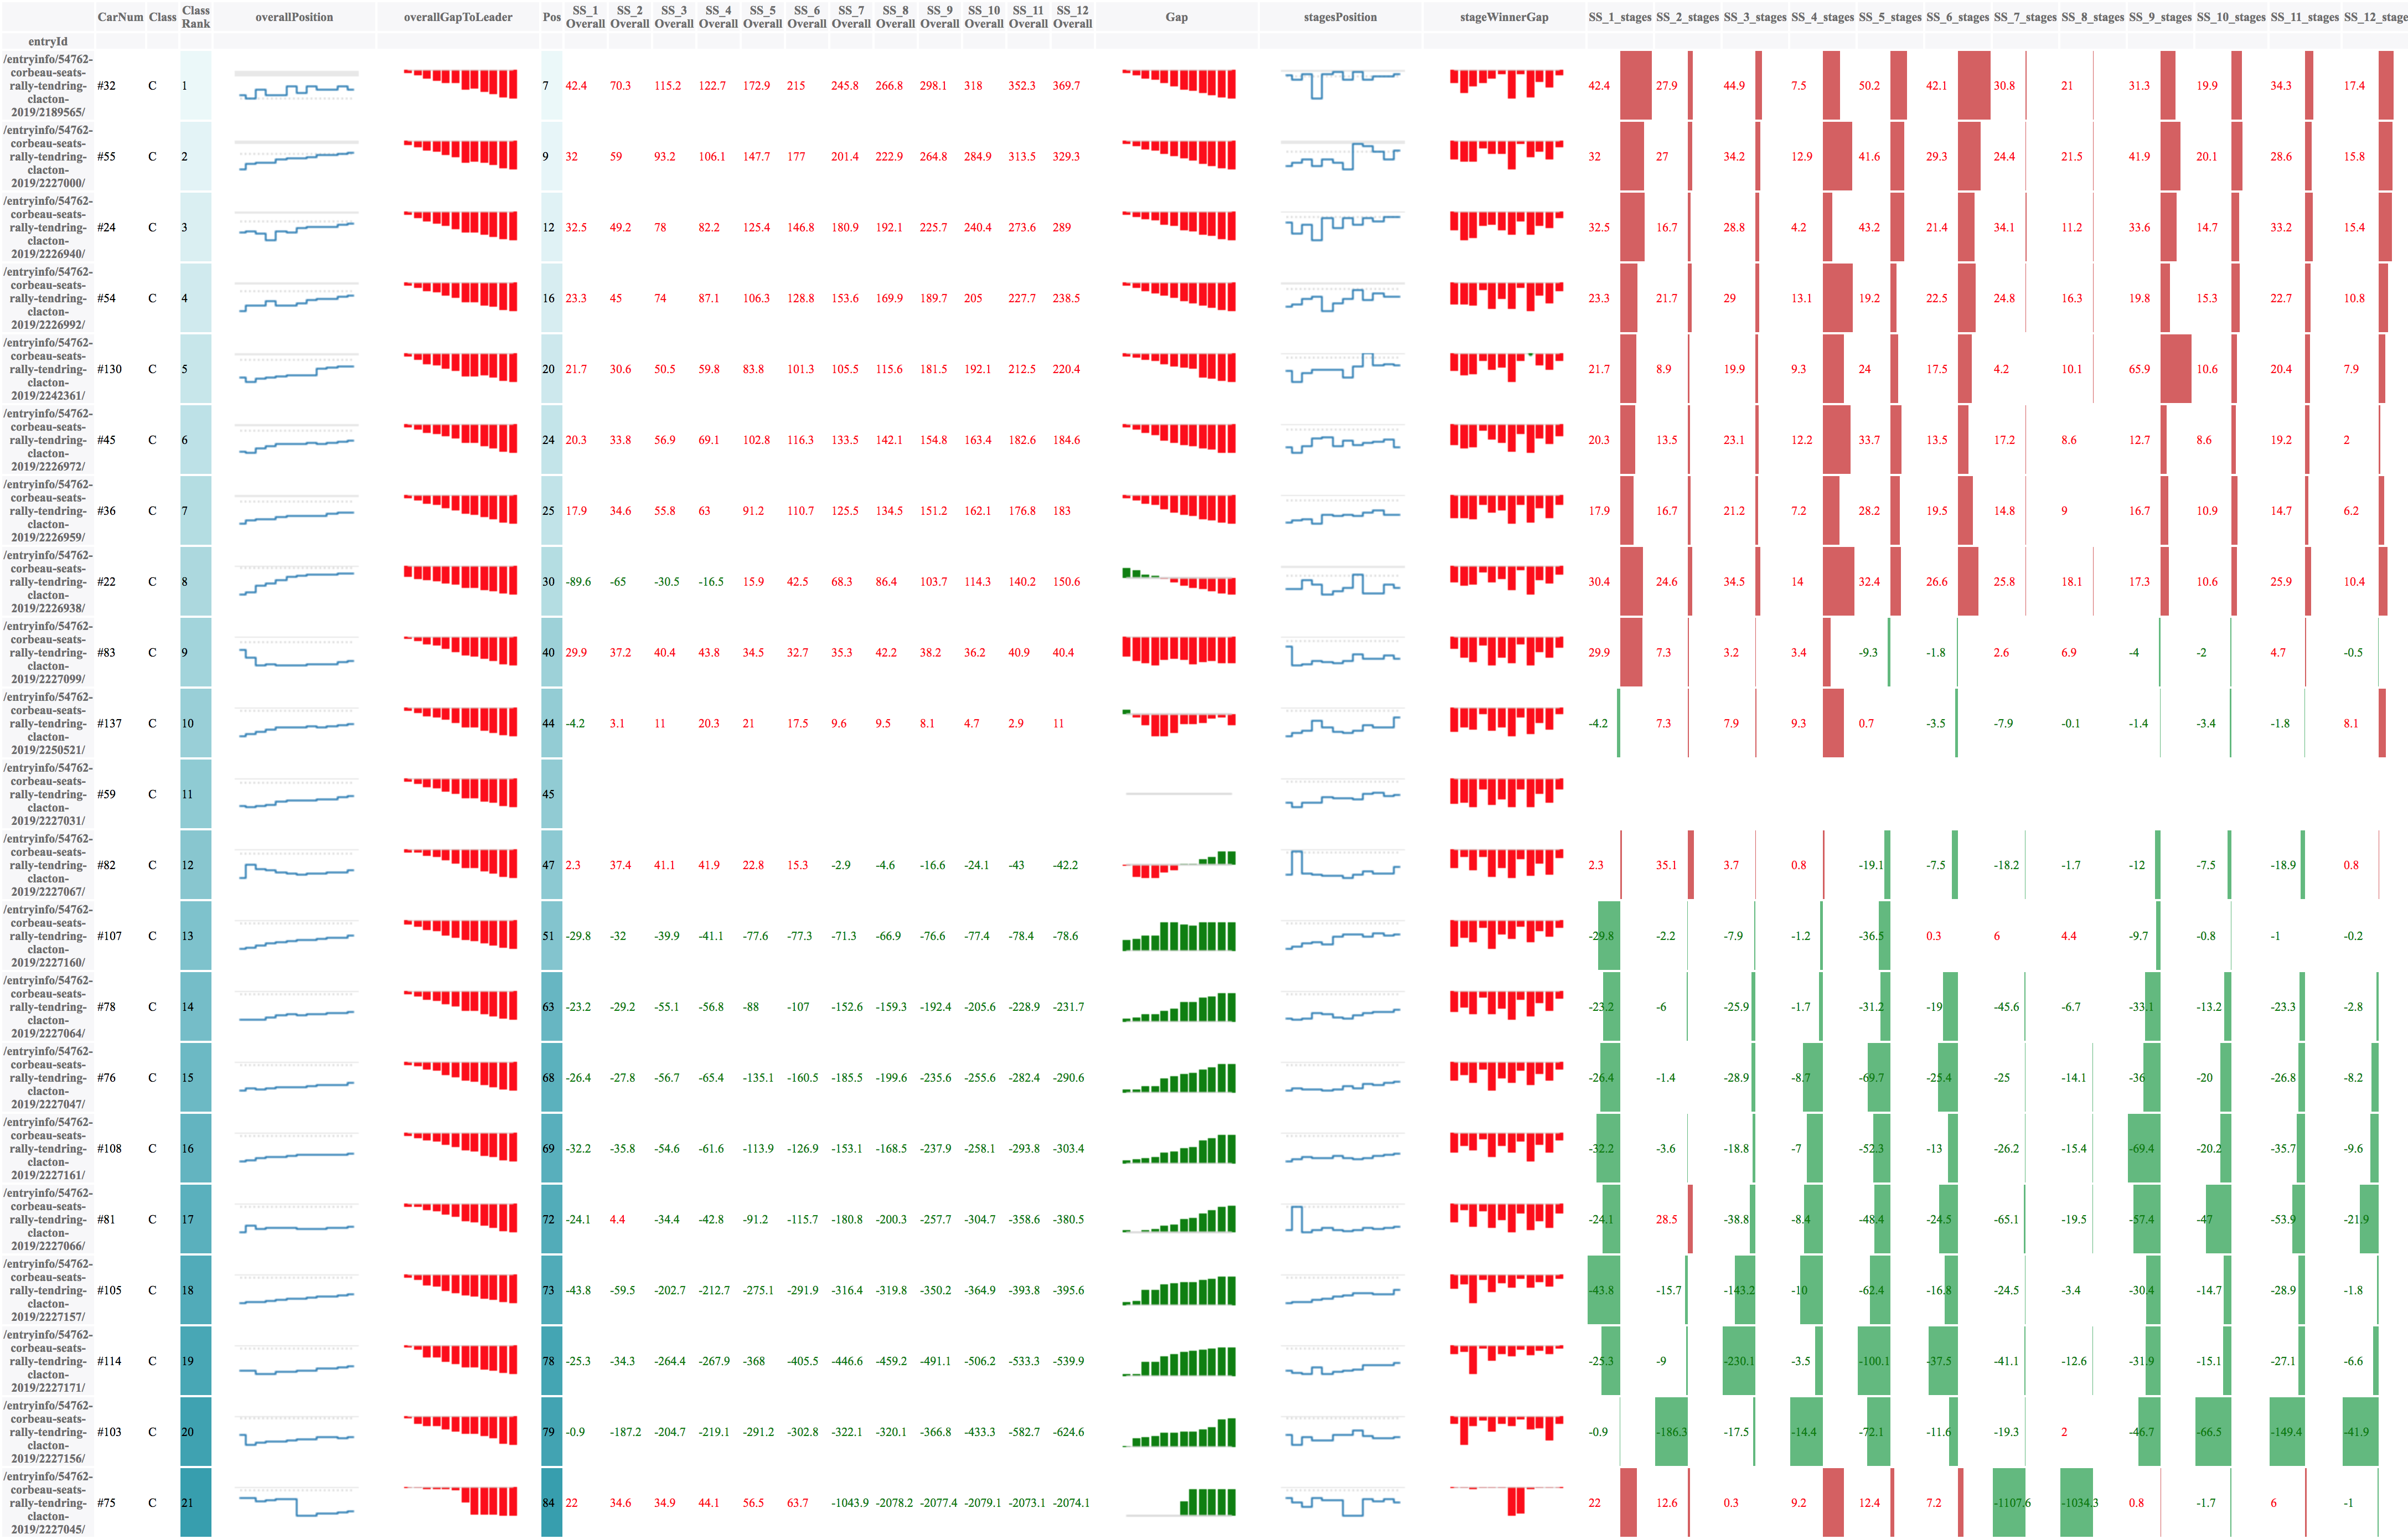

In [98]:
from IPython.display import Image
Image(_)

In [99]:
#TOP 20 overall
codes = pd.DataFrame(df_rally_overall[:20].index.tolist()).rename(columns={0:'entryId'}).set_index('entryId')
wREBASE=codes.iloc[7].name
print(wREBASE)
codes


/entryinfo/54762-corbeau-seats-rally-tendring-clacton-2019/2189564/


""
entryId
/entryinfo/54762-corbeau-seats-rally-tendring-clacton-2019/2189561/
/entryinfo/54762-corbeau-seats-rally-tendring-clacton-2019/2162347/
/entryinfo/54762-corbeau-seats-rally-tendring-clacton-2019/2226943/
/entryinfo/54762-corbeau-seats-rally-tendring-clacton-2019/2162362/
/entryinfo/54762-corbeau-seats-rally-tendring-clacton-2019/2162350/
/entryinfo/54762-corbeau-seats-rally-tendring-clacton-2019/2226888/
/entryinfo/54762-corbeau-seats-rally-tendring-clacton-2019/2189565/
/entryinfo/54762-corbeau-seats-rally-tendring-clacton-2019/2189564/
/entryinfo/54762-corbeau-seats-rally-tendring-clacton-2019/2227000/


Index(['/entryinfo/54762-corbeau-seats-rally-tendring-clacton-2019/2242361/'], dtype='object', name='entryId')
/entryinfo/54762-corbeau-seats-rally-tendring-clacton-2019/2242361/
Index(['/entryinfo/54762-corbeau-seats-rally-tendring-clacton-2019/2242361/'], dtype='object', name='entryId')
v Index(['/entryinfo/54762-corbeau-seats-rally-tendring-clacton-2019/2242361/'], dtype='object', name='entryId')
w Index(['/entryinfo/54762-corbeau-seats-rally-tendring-clacton-2019/2242361/'], dtype='object', name='entryId')
x Index(['/entryinfo/54762-corbeau-seats-rally-tendring-clacton-2019/2242361/'], dtype='object', name='entryId')
y Index(['/entryinfo/54762-corbeau-seats-rally-tendring-clacton-2019/2242361/'], dtype='object', name='entryId')
styling...
...done


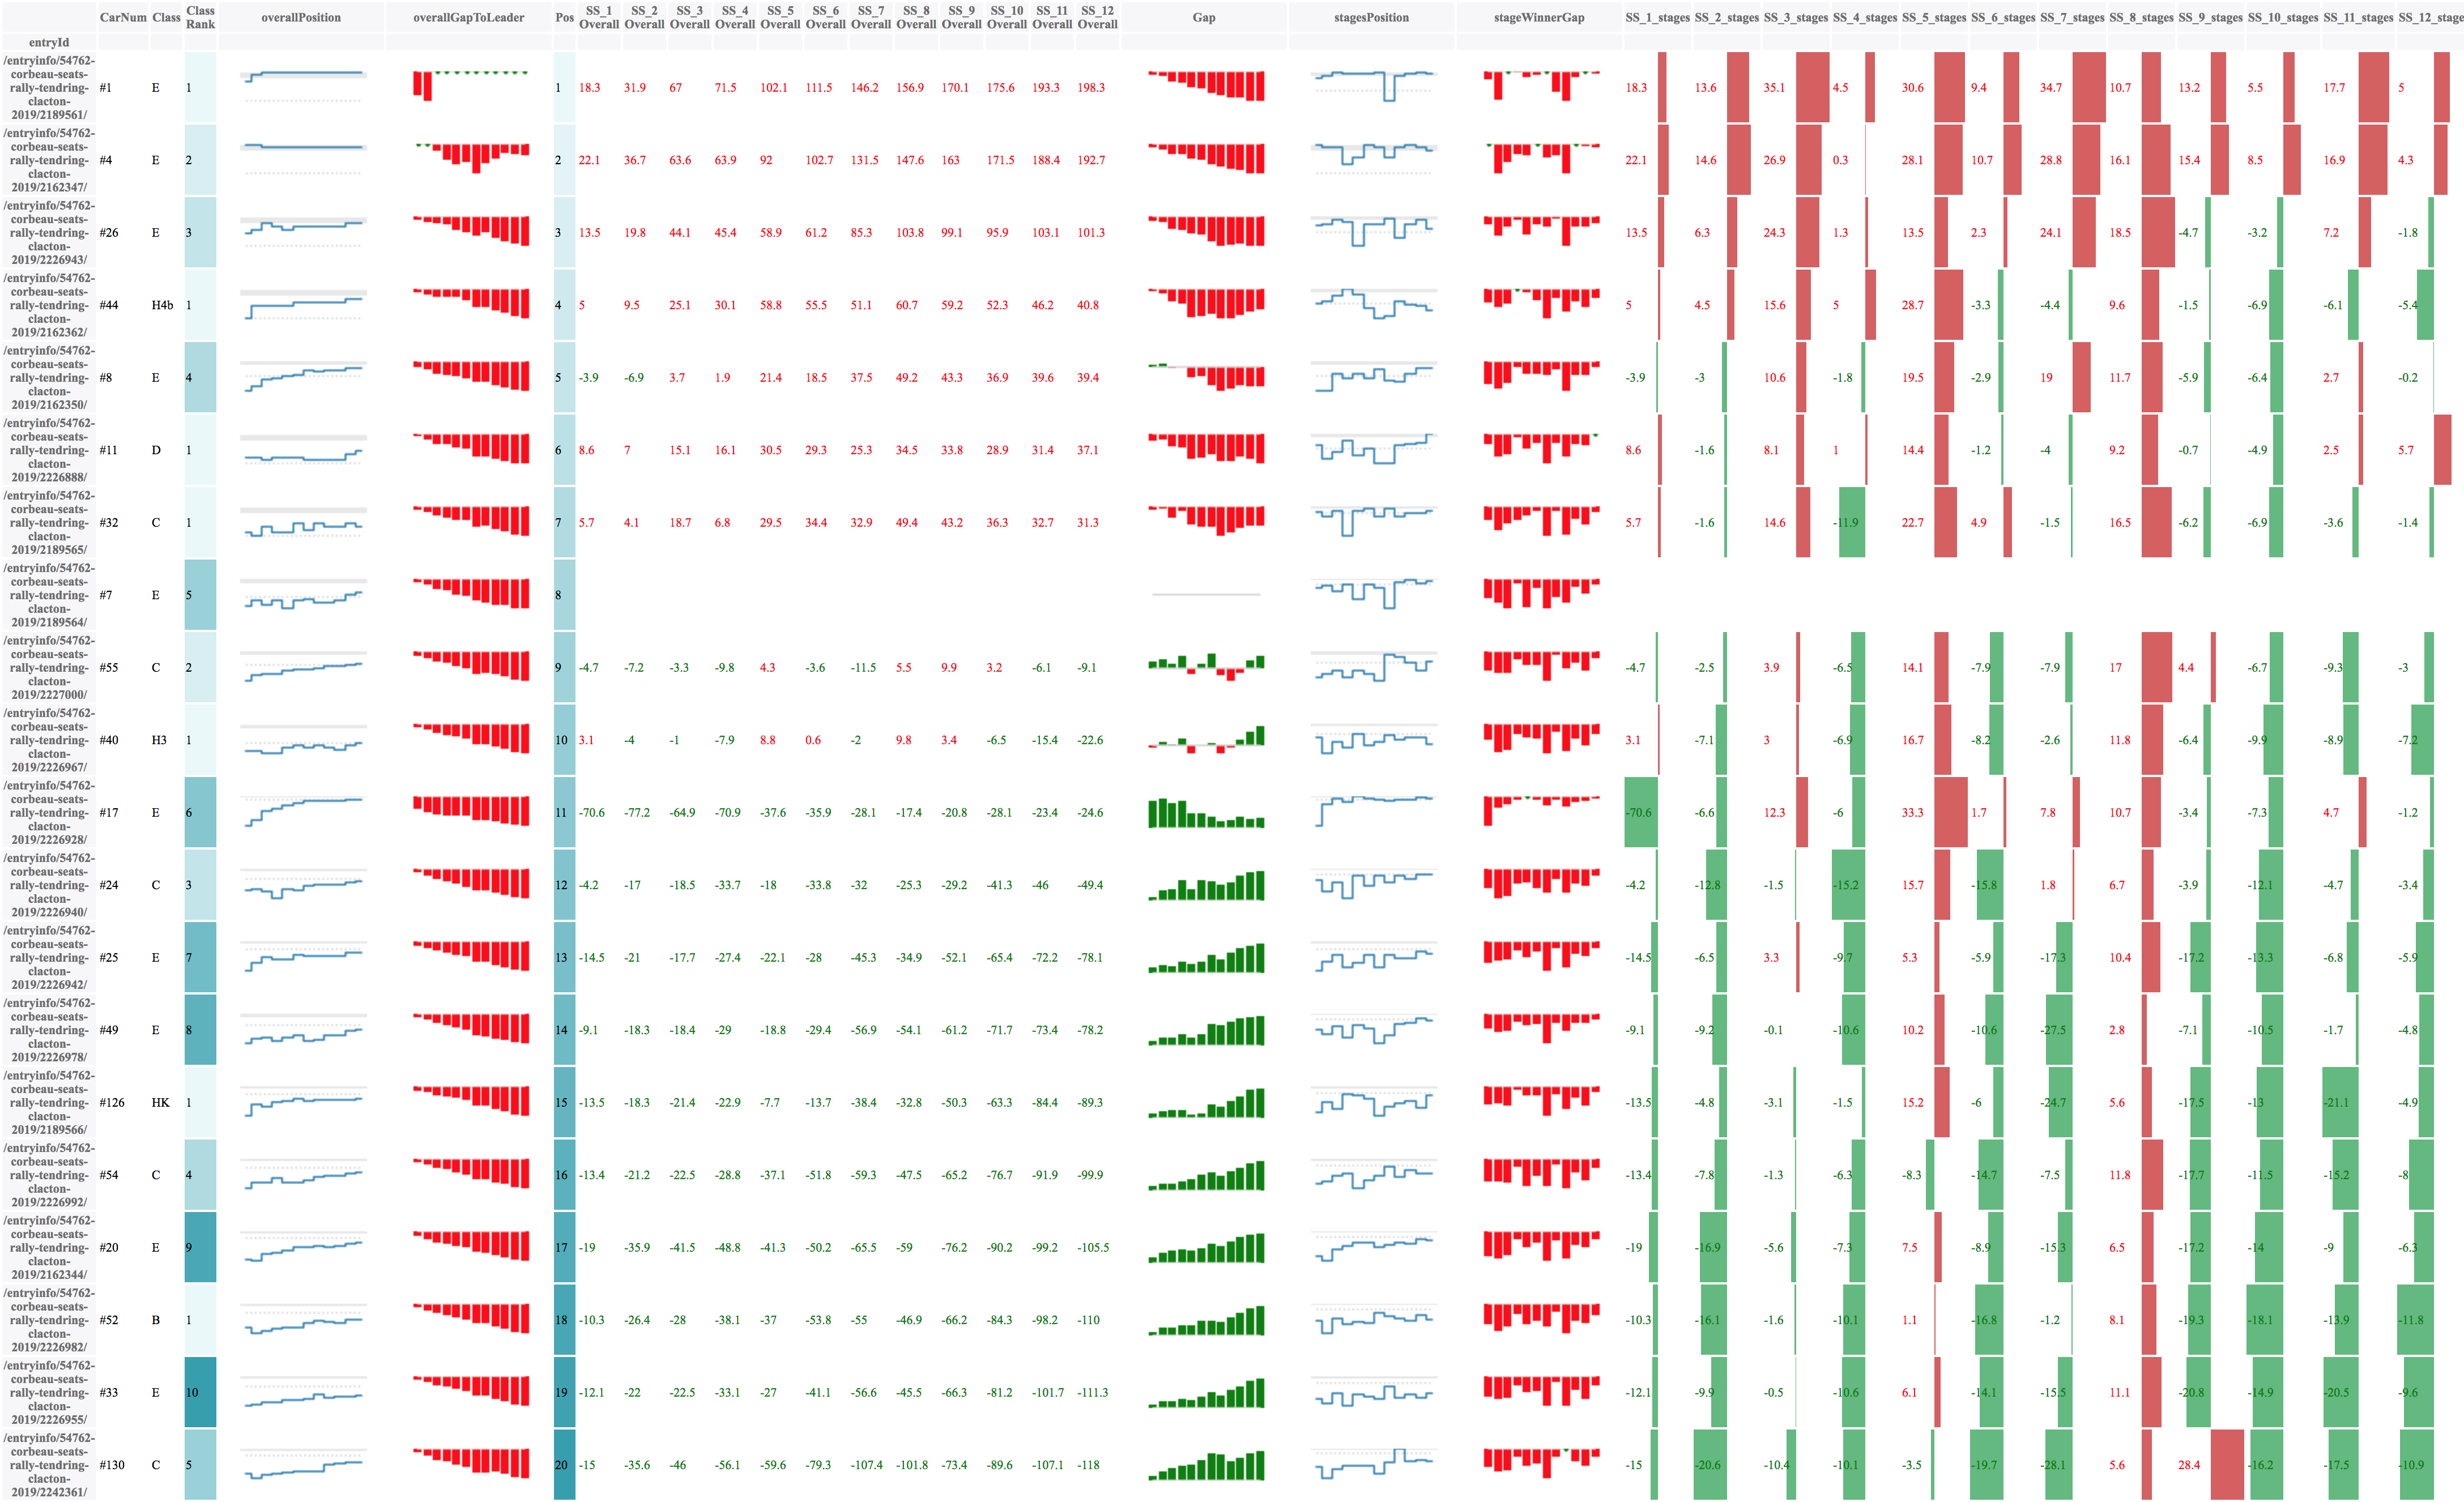

In [100]:
tmp, s2 = rally_report(df, codes, wREBASE)
_ = dakar.getTablePNG(s2, fnstub='overall_{}_'.format(wREBASE.replace('/','_')),scale_factor=2)
Image(_)

In [101]:
_

'testpng/overall__entryinfo_54762-corbeau-seats-rally-tendring-clacton-2019_2189564__.png'

## Widgets Example

Full results should cope with retirements because they affect stage rankings?

In [102]:
%%javascript
IPython.OutputArea.auto_scroll_threshold = 9999;


<IPython.core.display.Javascript object>

In [103]:
import ipywidgets as widgets
from ipywidgets import interact

classes = widgets.Dropdown(
    #Omit car 0
    options=['All']+df_entrylist[df_entrylist['CarNum']!='#0']['Class'].dropna().unique().tolist(),
    value='All', description='Class:', disabled=False )

def carsInClass(qclass):
    #Can't we also pass a dict of key/vals to the widget?
    #Omit car 0
    if qclass=='All':
        return df_entrylist[df_entrylist['CarNum']!='#0']['carNum'].dropna().to_list()
    return df_entrylist[df_entrylist['CarNum']!='#0' & df_entrylist['Class']==qclass]['carNum'].to_list()

carNum = widgets.Dropdown(
    options=carsInClass(classes.value),
    description='Car:', disabled=False)

def update_drivers(*args):
    carlist = carsInClass(classes.value)
    carNum.options = carlist
    
classes.observe(update_drivers, 'value')

def rally_report2(cl, carNum):
    #rebase = df_rally_overall[df_rally_overall['CarNum']==carNum].index[0]
    #carNums = df_rally_overall[df_rally_overall['CarNum'].isin(carsInClass(cl))].index.tolist()
    rebase = df[df['carNum']==carNum].index[0]

    carNums = df[df['carNum'].isin(carsInClass(cl))].index.tolist()

    codes = pd.DataFrame(carNums).rename(columns={0:'entryId'}).set_index('entryId')
    print(codes[-1:])
    tmp, s2 = rally_report(codes, rebase)

    #display(HTML(s2))
    rally_logo='<img width="100%" src="/Users/tonyhirst/Documents/GitHub/WRC_sketches/doodles/images/CSRTC-Logo-Banner-2019-01-1920x600-e1527255159629.jpg"/>'
    #rallydj_logo='<img style="float: left; src="/Users/tonyhirst/Documents/GitHub/WRC_sketches/doodles/images/rallydj.png"/>'
    #datasrc_logo='<img style="background-color:black;float: right;" src="/Users/tonyhirst/Documents/GitHub/WRC_sketches/doodles/images/ewrcresults800.png"/>'
    #bottom_logos='<div>'+rallydj_logo+datasrc_logo+'</div>'
    footer='<div style="margin-top:50px;margin-bottom:20px">Results and timing data sourced from <em>ewrc-results.com</em>. Chart generated by <em>rallydatajunkie.com</em>.</div>'
    #footer1=bottom_logos
    inclass='' if cl=='All' else ' (Class {})'.format(cl)
    title='<div><h1>Overall Results'+inclass+'</h1><p>Times rebased relative to car {}.</p></div>'.format(carNum)
    
    html='<div style="font-family:sans-serif;margin-top:10px;margin-bottom:10px"><div style="margin-top:10px;margin-bottom:50px;">'+rally_logo+'</div>'
    html = html+'<div style="margin-left:20px;margin-right:20px;">'+title+s2+'</div>'+footer+'</div>'
    
    print('grabbing screenshot...')
    _ = dakar.getTablePNG(html, fnstub='overall_{}_'.format(rebase.replace('/','_')),scale_factor=2)
    print('...done')
    display(Image(_))
    print(_)
    
interact(rally_report2, cl=classes, carNum=carNum);

TraitError: Invalid selection: value not found

In [98]:
#last is 2236623

In [99]:
df_entrylist.head()

,CarNum,DriverName,CoDriverName,Team,Car,Class,Meta,carNum
0,#0,Smith Allan,Butler Teresa,Allan Smith,Subaru Impreza STiR15 MYF,NaN,Course car,0
1,#1,Preston Thomas,Williamson Carl,Thomas Preston,Škoda Fabia R5SP 05-41,E,NaN,1
2,#2,Swann Robert,McNulty Steve,Robert Swann,Mitsubishi Mirage R5GM65 OHJ,E,NaN,2
3,#4,O'Brien Michael,Glennerster Mark,Michael O'Brien,Ford Focus RS WRC '07EA07 RGZ,E,NaN,4
4,#5,Davies Oliver,Innes Ben,Oliver Davies,Ford Escort MK2FCJ 249W,D,NaN,5


In [110]:
df.head()

,Pos,carModel,carNum,driver,navigator,overalltimes,penalties,positions,retired,stagetimes
entryId,,,,,,,,,,
/entryinfo/54762-corbeau-seats-rally-tendring-clacton-2019/2189561/,1.0,Škoda Fabia R5,1,Preston Thomas,Williamson Carl,"[6:17.3, 9:27.9, 14:32.4, 16:48.0, 23:05.3, 26...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[4, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]",False,"[6:17.3, 3:10.6, 5:04.5, 2:15.6, 6:17.3, 3:15...."
/entryinfo/54762-corbeau-seats-rally-tendring-clacton-2019/2162347/,2.0,Ford Focus RS WRC '07,4,O'Brien Michael,Glennerster Mark,"[6:13.5, 9:23.1, 14:35.8, 16:55.6, 23:15.4, 26...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]",False,"[6:13.5, 3:09.6, 5:12.7, 2:19.8, 6:19.8, 3:13...."
/entryinfo/54762-corbeau-seats-rally-tendring-clacton-2019/2226943/,3.0,Mitsubishi Lancer Evo IX,26,Jones Craig,Taylor Ian,"[6:22.1, 9:40.0, 14:55.3, 17:14.1, 23:48.5, 27...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[6, 5, 3, 4, 5, 4, 4, 4, 4, 4, 3, 3]",False,"[6:22.1, 3:17.9, 5:15.3, 2:18.8, 6:34.4, 3:22...."
/entryinfo/54762-corbeau-seats-rally-tendring-clacton-2019/2162362/,4.0,Mitsubishi Galant VR-4,44,Anderson Guy,Link Stephen,"[6:30.6, 9:50.3, 15:14.3, 17:29.4, 23:48.6, 27...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[10, 6, 6, 6, 6, 5, 5, 5, 5, 5, 4, 4]",False,"[6:30.6, 3:19.7, 5:24.0, 2:15.1, 6:19.2, 3:27...."
/entryinfo/54762-corbeau-seats-rally-tendring-clacton-2019/2162350/,5.0,Ford Fiesta R5,8,Self James,Davis Ian,"[6:39.5, 10:06.7, 15:35.7, 17:57.6, 24:26.0, 2...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[19, 16, 12, 11, 10, 9, 6, 7, 6, 6, 5, 5]",False,"[6:39.5, 3:27.2, 5:29.0, 2:21.9, 6:28.4, 3:27...."
